## Notebook purpose

The aim of that research is finding the way of estimating assets covariation<br>
The question of estimating the covariance matrix arises for the following reason:<br>
sometimes we need to now covariance between assets for efficient portfolio rebalancing or other goals,<br>
but some covariance coefficients can be distorted if the length of data sample (N) is comparable to the number of assets (T).<br>

Why? Because covariance matrix has about 0.5 * (N-1) * N params (where N is the number of assets). <br>
If the N/T ratio is near to 1 or even 0.01, we will use number of the observations comparable to the number of params that we estimate.<br>
That can lead to inadequate results. And in that step we need use some methods for matrix covariance matrix shrinkage.<br>

Shrinkage is a synonym to the compression. We make the biggest covariance matrix eigenvalues less bigger, and the smallest more bigger<br>
Eigenvalues correction will lead to the eigenvectors correction and will make ratios between them more balanced<br>
There are a lot of ways to do that, and in this notebook you will learn about 3 different types of shrinkage, <br>
compared to the base covariance matrix without any shrinkage. The inspiration and the math behiind them can be taken out of this article:<br>
https://www.zora.uzh.ch/id/eprint/170824/1/econwp231.pdf

In that notebook we will compare shrinkage methods in terms of proxy-volatility of portfolio at the each moment of testing<br>
You can add returns prediction and use predicted covariance matrices and predicted returns for portfolio optimization,<br>
that approach can be very powerfull.<br>

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import warnings

In [5]:
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
# List of assets 
DOW_JONES = [
    'AMZN', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX',
    'GS', 'HD', 'GE', 'IBM', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM',
    'MRK', 'MSFT', 'NKE', 'PG', 'SHW', 'UNH', 'CRM', 'NVDA',
    'VZ', 'V', 'WMT', 'DIS', 'T'
]
# excluded: TRV, changed to AT&T (ticker T)
# changed HON (to GE)

In [7]:
# base version of covariance matrix shrinkage
def compute_C_S(eps):
    return np.corrcoef(eps)

In [8]:
# L1 shrinkage (to the diagonal matrix)
def compute_C_L1(eps):
    lw = LedoitWolf().fit(eps.T)
    C_shrunk = lw.covariance_
    D = np.sqrt(np.diag(C_shrunk))
    return C_shrunk / np.outer(D, D)

In [9]:
# L2 shrinkage
def compute_C_L2(eps):
    C = np.corrcoef(eps)
    N, T = eps.shape
    off_diag_indices = np.triu_indices(N, k=1)
    rho_bar = np.mean(C[off_diag_indices])
    pi_hat = 0
    
    for i in range(N):
        for j in range(i+1, N):
            z_i = eps[i] / np.std(eps[i])
            z_j = eps[i] / np.std(eps[i])
            cov_ij = np.mean(z_i * z_j) - np.mean(z_i) * np.mean(z_j)
            var_c_ij = np.mean((z_i * z_j - cov_ij)**2) / T
            pi_hat += var_c_ij

    gamma_hat = np.sum((C[off_diag_indices] - rho_bar)**2)
    delta = pi_hat / (pi_hat + gamma_hat)
    delta = min(max(delta, 0), 1)
    F = np.ones((N, N)) * rho_bar
    np.fill_diagonal(F, 1)
    C_L2 = (1 - delta) * C + delta * F
    
    return C_L2

In [10]:
# Non-linear shrinkage (the most powerfull version of regularization for big number of assets)
def compute_C_NL(eps, c=None):
    # C is a base covariance matrix
    C = np.corrcoef(eps)
    # N is a number of assets, T is a number of observations
    N, T = eps.shape
    c = N / T if c is None else c
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    # Lambda coefficient from random matrix theory
    lambda_minus = (1 - np.sqrt(c)) ** 2 # Lower bound
    lambda_plus = (1 + np.sqrt(c)) ** 2 # Upper bound
    shrunk_eigenvalues = np.zeros_like(eigenvalues)
    for i, lam in enumerate(eigenvalues):
        # Eigenvalues correction
        if lambda_minus <= lam <= lambda_plus:
            shrunk_eigenvalues[i] = 1.0
        else:
            shrunk_eigenvalues[i] = lam / (1 + c)
    Lambda_shrunk = np.diag(shrunk_eigenvalues)       
    C_NL = eigenvectors @ Lambda_shrunk @ eigenvectors.T
    C_NL = (C_NL + C_NL.T) / 2
    min_eig = np.min(np.linalg.eigvals(C_NL))
    if min_eig < 0:
        C_NL += np.eye(N) * (-min_eig + 1e-6)
    return C_NL

In [11]:
# Objective function for garch-params calculation algorithm
def garch_objective(trial, returns, ticker):
    # Constraints are needed to avoid the algorithm getting stuck in a local minimum
    omega = trial.suggest_float(f'omega_{ticker}', 1e-6, 1e-4, log=True) # Base volatility level (very small number)  
    alpha = trial.suggest_float(f'alpha_{ticker}', 0.01, 0.2) # Previos residual influence
    beta = trial.suggest_float(f'beta_{ticker}', 0.7, 0.99) # Previous volatility influence
    # Sum of alpha and beta must not exceed 1 (that will lead to the exponential growth of params)
    if alpha + beta >= 1:
        return float('inf')
    try:
        sigma = compute_garch_volatility(returns, omega, alpha, beta)
        mu = np.mean(returns) 
        residuals = returns - mu # Residuals are the degree of deviation from the average level of the retainers
        log_likelihood = -0.5 * np.sum(np.log(sigma**2) + (residuals**2 / sigma**2)) # Log-likehood is a goal function for optimization
        return -log_likelihood
    except Exception as e:
        print(f'Trial for {ticker} failed: {e}')
        return float('inf')

In [12]:
# Garch-based volatility calculation after getting needed params
def compute_garch_volatility(returns, omega, alpha, beta):
    n = len(returns)
    sigma2 = np.zeros(n)
    mu = np.mean(returns)
    epsilon = returns - mu 
    sigma2[0] = np.var(returns)
    for t in range(1, n):
        sigma2[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma2[t-1]
    return np.sqrt(sigma2) # Square root of variance (volatility)

In [13]:
# Garch goal function optimization and diagonal matrix with volatilities calculation
def garch_for_all_assets_optuna(r, tickers, n_trials=50):
    n_assets, n_periods = r.shape
    params_dict = {}
    d = np.zeros((n_assets, n_periods))
    D_t_list = []
    for i, ticker in enumerate(tickers):
        print(f'GARCH(1,1) optimization for {ticker}:')
        study = optuna.create_study(direction='minimize') # Here optuna is the better option for optimization than scipy.optimize or neural networks
        study.optimize(lambda trial: garch_objective(trial, r[i, :], ticker), n_trials=n_trials)
        best_params = study.best_params
        omega = best_params[f'omega_{ticker}']
        alpha = best_params[f'alpha_{ticker}']
        beta = best_params[f'beta_{ticker}']
        params_dict[ticker] = {'omega': omega, 'alpha': alpha, 'beta': beta}
        d[i, :] = compute_garch_volatility(r[i, :], omega, alpha, beta) # Volatilities calculation
    for t in range(n_periods):
        D_t_list.append(np.diag(d[:, t])) # Diagonal matrix with volatilities on the main diagonal
    return params_dict, d, D_t_list

In [14]:
# Composite log-likehood function for DCC-params optimization
def composite_dcc_log_likelihood_optuna(params, eps, shrinkage='S'):
   # Alpha responsible for the previous residuals influnce, beta responsible for 
    alpha, beta = params
    n_assets, n_periods = eps.shape
    # Alpha and beta must not exceed one or be negative
    if alpha < 0 or beta < 0 or alpha + beta >= 1:
        return np.inf
    # Choosing type of covariance matrix shrinkage 
    if shrinkage == 'S':
        C = compute_C_S(eps)
    elif shrinkage == 'L1':
        C = compute_C_L1(eps)
    elif shrinkage == 'L2':
        C = compute_C_L2(eps)
    elif shrinkage == 'NL':
        C = compute_C_NL(eps)
    else:
        raise ValueError(f'Unknown shrinkage method: {shrinkage}')
    # Start matrix and goal function
    Q_t = C 
    log_likelihood = 0
    # Pair-cycle for likehood calculation 
    for t in range(1, n_periods):
        s_t1 = eps[:, t-1].reshape(-1, 1)
        # Dynamic covariance matrix Q_t depends on previos Q_t, C base covariance matrix (with choosen shrinkage option) and residuals on previos step
        Q_t = (1 - alpha - beta) * C + alpha * (s_t1 @ s_t1.T) + beta * Q_t
        Q_t_diag = np.sqrt(np.diag(Q_t)) 
        R_t = Q_t / (Q_t_diag[:, None] * Q_t_diag[None, :]) # R_t is the correlation matrix 
        for i in range(n_assets):
            for j in range(i + 1, n_assets):
                r_ij = R_t[i, j]
                if abs(r_ij) >= 1: 
                    return np.inf
                eps_i_t = eps[i, t]
                eps_j_t = eps[j, t]
                log_likelihood -= 0.5 * (
                    np.log(1 - r_ij**2) + 
                    (eps_i_t**2 + eps_j_t**2 - 2 * r_ij * eps_i_t * eps_j_t) / (1 - r_ij**2)
                )
    return -log_likelihood

In [15]:
# DCC optimization step 
def estimate_dcc_params_optuna(eps, shrinkage='S', n_trials=50):
    def objective(trial):
        # Constrains are needed to avoid the algorithm getting stuck in a local minimum
        alpha = trial.suggest_float('alpha', 1e-5, 0.2) # Typically alpha is much smaller than beta  
        beta = trial.suggest_float('beta', 0.7, 0.99) 
        params = [alpha, beta]
        return composite_dcc_log_likelihood_optuna(params, eps, shrinkage)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    best_params = study.best_params
    alpha = best_params['alpha']
    beta = best_params['beta']
    if study.best_value == np.inf:
        raise ValueError('DCC optimization failed')
    return np.array([alpha, beta])

In [16]:
# Out-of-sample garch volatility calculation
def compute_garch_volatility_test(returns, omega, alpha, beta, initial_sigma2=None):
    n = len(returns)
    sigma2 = np.zeros(n)
    mu = np.mean(returns) 
    epsilon = returns - mu 
    if initial_sigma2 is None:
        sigma2[0] = np.var(returns)
    else:
        sigma2[0] = initial_sigma2
    for t in range(1, n):
        sigma2[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma2[t-1]
    return np.sqrt(sigma2)

In [17]:
# Out-of-sample covariance matrices calculation
def compute_Q_t_optuna(eps, alpha, beta, shrinkage='S', initial_Q=None):
    n_assets, n_periods = eps.shape
    if shrinkage == 'S':
        C = compute_C_S(eps)
    elif shrinkage == 'L1':
        C = compute_C_L1(eps)
    elif shrinkage == 'L2':
        C = compute_C_L2(eps)
    elif shrinkage == 'NL':
        C = compute_C_NL(eps)
    else:
        raise ValueError(f'Unknown shrinkage method: {shrinkage}')
    Q_t_list = []
    Q_t = initial_Q if initial_Q is not None else C
    for t in range(n_periods):
        Q_t_list.append(Q_t)
        if t < n_periods - 1:
            s_t = eps[:, t].reshape(-1, 1)
            Q_t = (1 - alpha - beta) * C + alpha * (s_t @ s_t.T) + beta * Q_t
    return Q_t_list, C

In [18]:
# Out-of-sample diagonal matrices calculation
def garch_for_test_data(r_out, tickers, params_dict, initial_vols=None):
    n_assets, n_periods = r_out.shape
    d_out = np.zeros((n_assets, n_periods))
    D_t_list_out = []
    for i, ticker in enumerate(tickers):
        omega = params_dict[ticker]['omega']
        alpha = params_dict[ticker]['alpha']
        beta = params_dict[ticker]['beta']
        initial_sigma2 = initial_vols[i] if initial_vols is not None else None
        d_out[i, :] = compute_garch_volatility_test(r_out[i, :], omega, alpha, beta, initial_sigma2)
    for t in range(n_periods):
        D_t_list_out.append(np.diag(d_out[:, t]))
    return d_out, D_t_list_out

In [19]:
# Correlation and accurate covariance matrices calculation 
def compute_R_t_H_t(Q_t_list, D_t_list):
    R_t_list = []
    H_t_list = []
    for t in range(len(Q_t_list)):
        Q_t = Q_t_list[t]
        Q_t_diag_sqrt = np.sqrt(np.diag(Q_t))  
        Q_t_diag_inv_sqrt = np.diag(1 / Q_t_diag_sqrt)  
        # Correlation matrix calculation (with ones on the main diagonal)
        R_t = Q_t_diag_inv_sqrt @ Q_t @ Q_t_diag_inv_sqrt
        R_t_list.append(R_t)
        D_t = D_t_list[t]
        # Accurate covariance matrix (wich includes garch-volatility influence)
        H_t = D_t @ R_t @ D_t
        H_t_list.append(H_t)
    return R_t_list, H_t_list

In [20]:
# Prepearing test and train fractions of log-returns
# Perspective param is only about file data lenghts, frequency is about price changing data frequency
def returns_preparation(DOW_JONES, frequency='15MIN', perspective='LONG',
                        train_fraction=0.8, start_overall='2010-01-04 14:30:00', 
                        end_overall='2011-01-04 14:30:00', date_format='%Y-%m-%dT%H:%M:%SZ'):

    ticker = 'AMZN'
    data = pd.read_csv(f'DOW_JONES_{frequency}_{perspective}/{ticker}.csv', index_col='timestamp')
    data.index = pd.to_datetime(data.index, format=date_format)
    data[f'log_ret_start'] = np.log(data['close'] / data['close'].shift(1))
    columns_to_drop = ['open', 'high', 'low', 'close', 'volume']
    data = data.drop(columns_to_drop, axis=1, errors='ignore')
    data = data.fillna(0)
    for ticker in DOW_JONES:
        data_new = pd.read_csv(f'DOW_JONES_15MIN_LONG/{ticker}.csv', index_col='timestamp')
        data_new.index = pd.to_datetime(data_new.index, format=date_format)
        data_new[f'log_ret_{ticker}'] = np.log(data_new['close'] / data_new['close'].shift(1))
        data_new = data_new.drop(columns_to_drop, axis=1, errors='ignore')
        data_new = data_new.fillna(0)
        data = pd.concat([data, data_new], axis=1)
    
    data = data.drop(data.columns[0], axis=1, errors='ignore')
    data = data.fillna(0)

    req_start = pd.to_datetime(start_overall)
    req_end = pd.to_datetime(end_overall)
    potential_starts = data.index[data.index >= req_start]
    if len(potential_starts) == 0:
        raise ValueError(f'No data available at or after {req_start}')
    actual_start = potential_starts[0]
    potential_ends = data.index[data.index <= req_end]
    if len(potential_ends) == 0:
        raise ValueError(f'No data available at or before {req_end}')
    actual_end = potential_ends[-1]
    if actual_end < actual_start:
        raise ValueError(f'Actual end {actual_end} is before actual start {actual_start}')
    data_range = data.loc[actual_start:actual_end]
    train_size = int(train_fraction * len(data_range))
    X_train = data_range[:train_size]
    X_test = data_range[train_size:]
    r = X_train.to_numpy().T
    r_out = X_test.to_numpy().T
    
    return r, r_out

In [21]:
# Combining all previous functions
def all_steps_in_one_place(DOW_JONES, frequency='15MIN', perspective='LONG',
                        train_fraction=0.8, method='S', start_overall = '2010-01-04 14:30:00', 
                        end_overall = '2011-01-04 14:30:00', date_format='%Y-%m-%dT%H:%M:%SZ'):
    
    r, r_out = returns_preparation(DOW_JONES, frequency=frequency, perspective=perspective,
                        train_fraction=train_fraction, start_overall=start_overall, 
                        end_overall=end_overall, date_format=date_format)
    params_dict, d, D_t_list = garch_for_all_assets_optuna(r, DOW_JONES, n_trials=50)
    eps = r / d
    alpha, beta = estimate_dcc_params_optuna(eps, shrinkage=method, n_trials=50)
    Q_t_list, C = compute_Q_t_optuna(eps, alpha, beta, shrinkage=method)
    initial_vols = [d[i, -1]**2 for i in range(len(DOW_JONES))]
    d_out, D_t_list_out = garch_for_test_data(r_out, DOW_JONES, params_dict, initial_vols)
    eps_out = r_out / d_out
    initial_Q = Q_t_list[-1]
    Q_t_list_out, C_out = compute_Q_t_optuna(eps_out, alpha, beta, shrinkage=method, initial_Q=initial_Q)
    R_t_list, H_t_list = compute_R_t_H_t(Q_t_list, D_t_list)
    R_t_list_out, H_t_list_out = compute_R_t_H_t(Q_t_list_out, D_t_list_out)

    return H_t_list, H_t_list_out, R_t_list, R_t_list_out, alpha, beta

In [22]:
# Proxy-volatility calculation (based only on covariance matrix, not on real data returns)
def proxy_volatility_calculation(H_t_list):
    volatilities_list = []
    for i in range(len(H_t_list)):
        # H_t is a covariance matrix
        H_t = H_t_list[i]
        # Getting sorted lists of eigenvalues and corresponded eigenvectors of covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(H_t)
        # Eigenvectors[-1] is an eigenvector corresponded to the smallest eigenvalue of covariance matrix
        # That step is needed to find the weights vector, that explains the smallest part of assets variance (in can be named "reversed PCA")
        # Corrected vector is the least variance vector normalized to sum of value equal to 1 
        corrected_vector = np.array([eigenvectors[-1][i] / sum(eigenvectors[-1]) for i in range(len(eigenvectors[-1]))])
        # Proxy volatility (volatility at the moment without using real returns, only with weights vector and covariance matrix)
        volatility = float(corrected_vector @ H_t @ corrected_vector.T)
        volatilities_list.append(volatility)
        
    return volatilities_list

In [26]:
# Different shrinkage types volatility comparison function
def volatility_comparison(DOW_JONES, frequency='15MIN', perspective='LONG',
                        train_fraction=0.8, method='NL', start_overall='2010-01-04 14:30:00', 
                        end_overall='2010-01-30 14:30:00', date_format='%Y-%m-%dT%H:%M:%SZ'):
    results = {}
    volatility_results = {}
    for method in ['S', 'L1', 'L2', 'NL']:
        method_dict = {}
        vol_method_dict = {}
        H_t_list, H_t_list_out, R_t_list, R_t_list_out, alpha, beta = all_steps_in_one_place(DOW_JONES, frequency=frequency, 
                            perspective=perspective, train_fraction=train_fraction, method=method, start_overall=start_overall, 
                            end_overall=end_overall, date_format=date_format)
        volatilities_list = proxy_volatility_calculation(H_t_list)
        volatilities_list_out = proxy_volatility_calculation(H_t_list_out)
        method_dict['In sample volatility'] = round(np.mean(volatilities_list) * 10000, 3)
        method_dict['Out of sample volatility'] = round(np.mean(volatilities_list_out) * 10000, 3)
        vol_method_dict['volatilities in-sample list'] = volatilities_list
        vol_method_dict['volatilities out-of-sample list'] = volatilities_list_out
        results[method] = method_dict
        volatility_results[method] = vol_method_dict
    
    return results, volatility_results

In [27]:
# Example of possible params
results, volatility_results = volatility_comparison(DOW_JONES, frequency='15MIN', perspective='LONG',
                        train_fraction=0.8, method='NL', start_overall='2012-01-01 14:30:00', 
                        end_overall='2012-01-30 14:30:00', date_format='%Y-%m-%dT%H:%M:%SZ')

[I 2025-09-16 21:44:18,323] A new study created in memory with name: no-name-b3cc43e8-d6d9-4315-8d75-13d530aaece4
[I 2025-09-16 21:44:18,324] Trial 0 finished with value: inf and parameters: {'omega_AMZN': 5.114774702060801e-05, 'alpha_AMZN': 0.1403922809350128, 'beta_AMZN': 0.949086794199301}. Best is trial 0 with value: inf.
[I 2025-09-16 21:44:18,325] Trial 1 finished with value: -1870.7570761140737 and parameters: {'omega_AMZN': 3.99845070672089e-06, 'alpha_AMZN': 0.07856497257884124, 'beta_AMZN': 0.8026347208947774}. Best is trial 1 with value: -1870.7570761140737.
[I 2025-09-16 21:44:18,327] Trial 2 finished with value: -1880.1410257134373 and parameters: {'omega_AMZN': 1.3492748226274732e-06, 'alpha_AMZN': 0.1525146138019629, 'beta_AMZN': 0.8344065533250451}. Best is trial 2 with value: -1880.1410257134373.
[I 2025-09-16 21:44:18,328] Trial 3 finished with value: inf and parameters: {'omega_AMZN': 5.1655187706072486e-05, 'alpha_AMZN': 0.10749966644411238, 'beta_AMZN': 0.94524130

GARCH(1,1) optimization for AMZN:


[I 2025-09-16 21:44:18,531] Trial 30 finished with value: -1900.0169478894782 and parameters: {'omega_AMZN': 1.8656970161992016e-06, 'alpha_AMZN': 0.09399788961426173, 'beta_AMZN': 0.7786554588458422}. Best is trial 21 with value: -1902.755650710263.
[I 2025-09-16 21:44:18,541] Trial 31 finished with value: -1895.6722595229685 and parameters: {'omega_AMZN': 1.7528878010568637e-06, 'alpha_AMZN': 0.09388320510068636, 'beta_AMZN': 0.8192548773642913}. Best is trial 21 with value: -1902.755650710263.
[I 2025-09-16 21:44:18,550] Trial 32 finished with value: -1891.437094839543 and parameters: {'omega_AMZN': 3.3051773777191993e-06, 'alpha_AMZN': 0.07790904601420537, 'beta_AMZN': 0.7809406920663516}. Best is trial 21 with value: -1902.755650710263.
[I 2025-09-16 21:44:18,559] Trial 33 finished with value: -1870.5425188002919 and parameters: {'omega_AMZN': 4.835312613034981e-06, 'alpha_AMZN': 0.12899147178963766, 'beta_AMZN': 0.7452362145537968}. Best is trial 21 with value: -1902.755650710263

GARCH(1,1) optimization for AXP:


[I 2025-09-16 21:44:18,922] Trial 32 finished with value: -1969.6116850683075 and parameters: {'omega_AXP': 1.9793181446373372e-06, 'alpha_AXP': 0.029956285947008, 'beta_AXP': 0.7883344991363853}. Best is trial 18 with value: -1971.7623551044528.
[I 2025-09-16 21:44:18,932] Trial 33 finished with value: -1967.358797051351 and parameters: {'omega_AXP': 1.4169130665714123e-06, 'alpha_AXP': 0.07930209133197998, 'beta_AXP': 0.8049598080501829}. Best is trial 18 with value: -1971.7623551044528.
[I 2025-09-16 21:44:18,941] Trial 34 finished with value: -1939.898806740502 and parameters: {'omega_AXP': 2.9755938150202327e-06, 'alpha_AXP': 0.022395764559737328, 'beta_AXP': 0.7932927675480849}. Best is trial 18 with value: -1971.7623551044528.
[I 2025-09-16 21:44:18,950] Trial 35 finished with value: -1923.8531116022339 and parameters: {'omega_AXP': 1.925071197706817e-06, 'alpha_AXP': 0.11631574942662218, 'beta_AXP': 0.8376770257675893}. Best is trial 18 with value: -1971.7623551044528.
[I 2025-

GARCH(1,1) optimization for AMGN:


[I 2025-09-16 21:44:19,282] Trial 30 finished with value: -2041.1496558154965 and parameters: {'omega_AMGN': 2.684190882686934e-06, 'alpha_AMGN': 0.1473092310700588, 'beta_AMGN': 0.7149463849776094}. Best is trial 13 with value: -2105.130331336194.
[I 2025-09-16 21:44:19,292] Trial 31 finished with value: -2099.4450014553377 and parameters: {'omega_AMGN': 1.0080882956909207e-06, 'alpha_AMGN': 0.03227830948148293, 'beta_AMGN': 0.7958395325126927}. Best is trial 13 with value: -2105.130331336194.
[I 2025-09-16 21:44:19,302] Trial 32 finished with value: -2099.3847156152065 and parameters: {'omega_AMGN': 1.2927534254457175e-06, 'alpha_AMGN': 0.03158785981255181, 'beta_AMGN': 0.751561237381473}. Best is trial 13 with value: -2105.130331336194.
[I 2025-09-16 21:44:19,312] Trial 33 finished with value: -2057.1719521190544 and parameters: {'omega_AMGN': 1.8352703280156796e-06, 'alpha_AMGN': 0.035468947524370034, 'beta_AMGN': 0.7998609091795839}. Best is trial 13 with value: -2105.130331336194

GARCH(1,1) optimization for AAPL:


[I 2025-09-16 21:44:19,667] Trial 31 finished with value: -2118.471012405797 and parameters: {'omega_AAPL': 1.2073991387762226e-06, 'alpha_AAPL': 0.05018965467602974, 'beta_AAPL': 0.7728041453570262}. Best is trial 28 with value: -2128.705726780445.
[I 2025-09-16 21:44:19,676] Trial 32 finished with value: -2108.9735992369174 and parameters: {'omega_AAPL': 1.3522868440564949e-06, 'alpha_AAPL': 0.04674187981235879, 'beta_AAPL': 0.7783870643223596}. Best is trial 28 with value: -2128.705726780445.
[I 2025-09-16 21:44:19,685] Trial 33 finished with value: -2103.0294897339472 and parameters: {'omega_AAPL': 1.3923293984400958e-06, 'alpha_AAPL': 0.018834966474824348, 'beta_AAPL': 0.80260684480963}. Best is trial 28 with value: -2128.705726780445.
[I 2025-09-16 21:44:19,695] Trial 34 finished with value: -2125.9138845523303 and parameters: {'omega_AAPL': 1.3412436490946477e-06, 'alpha_AAPL': 0.02398632294761627, 'beta_AAPL': 0.7469056065304588}. Best is trial 28 with value: -2128.705726780445

GARCH(1,1) optimization for BA:


[I 2025-09-16 21:44:20,040] Trial 31 finished with value: -2049.2848768006425 and parameters: {'omega_BA': 1.2214043016397889e-06, 'alpha_BA': 0.05810094954169838, 'beta_BA': 0.7231311958712862}. Best is trial 31 with value: -2049.2848768006425.
[I 2025-09-16 21:44:20,049] Trial 32 finished with value: -2047.2620097942327 and parameters: {'omega_BA': 1.0940494067799953e-06, 'alpha_BA': 0.061658751033675664, 'beta_BA': 0.7537366207074019}. Best is trial 31 with value: -2049.2848768006425.
[I 2025-09-16 21:44:20,059] Trial 33 finished with value: -2044.7740423321807 and parameters: {'omega_BA': 1.918484210633149e-06, 'alpha_BA': 0.028895611395402577, 'beta_BA': 0.7228598837502771}. Best is trial 31 with value: -2049.2848768006425.
[I 2025-09-16 21:44:20,068] Trial 34 finished with value: -1762.2652444845091 and parameters: {'omega_BA': 1.5717987041736083e-05, 'alpha_BA': 0.05365295524247218, 'beta_BA': 0.7514257172044551}. Best is trial 31 with value: -2049.2848768006425.
[I 2025-09-16 2

GARCH(1,1) optimization for CAT:


[I 2025-09-16 21:44:20,421] Trial 32 finished with value: -1943.8599984511275 and parameters: {'omega_CAT': 1.9132868514597667e-06, 'alpha_CAT': 0.09552895793180308, 'beta_CAT': 0.721533483682607}. Best is trial 32 with value: -1943.8599984511275.
[I 2025-09-16 21:44:20,431] Trial 33 finished with value: -1945.3751110651074 and parameters: {'omega_CAT': 1.867998975344534e-06, 'alpha_CAT': 0.09045939071817993, 'beta_CAT': 0.7192842050918645}. Best is trial 33 with value: -1945.3751110651074.
[I 2025-09-16 21:44:20,440] Trial 34 finished with value: -1942.4890725783018 and parameters: {'omega_CAT': 1.4498268774473218e-06, 'alpha_CAT': 0.09028813353374174, 'beta_CAT': 0.7529717113427101}. Best is trial 33 with value: -1945.3751110651074.
[I 2025-09-16 21:44:20,449] Trial 35 finished with value: -1929.3403448536237 and parameters: {'omega_CAT': 2.9711748608134895e-06, 'alpha_CAT': 0.11113813118218391, 'beta_CAT': 0.7021654257155812}. Best is trial 33 with value: -1945.3751110651074.
[I 202

GARCH(1,1) optimization for CSCO:


[I 2025-09-16 21:44:20,794] Trial 32 finished with value: -1981.6318072038903 and parameters: {'omega_CSCO': 2.0354201128451624e-06, 'alpha_CSCO': 0.04361779888660523, 'beta_CSCO': 0.7578302014174678}. Best is trial 9 with value: -1992.254841821191.
[I 2025-09-16 21:44:20,803] Trial 33 finished with value: -1993.9791566281124 and parameters: {'omega_CSCO': 1.1205318785592267e-06, 'alpha_CSCO': 0.025449304099625508, 'beta_CSCO': 0.7921723628218964}. Best is trial 33 with value: -1993.9791566281124.
[I 2025-09-16 21:44:20,812] Trial 34 finished with value: -1991.4524880414604 and parameters: {'omega_CSCO': 1.019705765731224e-06, 'alpha_CSCO': 0.047292742103622776, 'beta_CSCO': 0.794995698088998}. Best is trial 33 with value: -1993.9791566281124.
[I 2025-09-16 21:44:20,820] Trial 35 finished with value: -1990.2837694107893 and parameters: {'omega_CSCO': 1.156099405545817e-06, 'alpha_CSCO': 0.023178992095037917, 'beta_CSCO': 0.8342812114317313}. Best is trial 33 with value: -1993.979156628

GARCH(1,1) optimization for CVX:


[I 2025-09-16 21:44:21,167] Trial 25 finished with value: -1989.7060406477017 and parameters: {'omega_CVX': 1.5511359964556268e-06, 'alpha_CVX': 0.05399907292554698, 'beta_CVX': 0.8233180427554955}. Best is trial 21 with value: -2017.85920588944.
[I 2025-09-16 21:44:21,176] Trial 26 finished with value: -2000.9116286508704 and parameters: {'omega_CVX': 2.231405568922233e-06, 'alpha_CVX': 0.02224365880804884, 'beta_CVX': 0.7545221489044273}. Best is trial 21 with value: -2017.85920588944.
[I 2025-09-16 21:44:21,189] Trial 27 finished with value: -1946.2699559426205 and parameters: {'omega_CVX': 3.119274943700288e-06, 'alpha_CVX': 0.0879323895821345, 'beta_CVX': 0.7762241225137908}. Best is trial 21 with value: -2017.85920588944.
[I 2025-09-16 21:44:21,201] Trial 28 finished with value: -1819.6610381425885 and parameters: {'omega_CVX': 7.254187885965928e-06, 'alpha_CVX': 0.05129516847166801, 'beta_CVX': 0.8095265289636961}. Best is trial 21 with value: -2017.85920588944.
[I 2025-09-16 21

GARCH(1,1) optimization for GS:


[I 2025-09-16 21:44:21,618] Trial 31 finished with value: -1803.545893174924 and parameters: {'omega_GS': 4.3210532518884545e-06, 'alpha_GS': 0.06421714724286183, 'beta_GS': 0.7252756165692267}. Best is trial 22 with value: -1806.0135203788116.
[I 2025-09-16 21:44:21,628] Trial 32 finished with value: -1764.2515287000442 and parameters: {'omega_GS': 2.7020636757671175e-06, 'alpha_GS': 0.07941247920042149, 'beta_GS': 0.7016706670536617}. Best is trial 22 with value: -1806.0135203788116.
[I 2025-09-16 21:44:21,637] Trial 33 finished with value: -1805.384540332595 and parameters: {'omega_GS': 7.2013653747776094e-06, 'alpha_GS': 0.03162988299995739, 'beta_GS': 0.7186618004703265}. Best is trial 22 with value: -1806.0135203788116.
[I 2025-09-16 21:44:21,646] Trial 34 finished with value: -1791.9075644650623 and parameters: {'omega_GS': 7.736554587703787e-06, 'alpha_GS': 0.02927545101118642, 'beta_GS': 0.7606694915590537}. Best is trial 22 with value: -1806.0135203788116.
[I 2025-09-16 21:44

GARCH(1,1) optimization for HD:


[I 2025-09-16 21:44:22,000] Trial 32 finished with value: -2087.657491156037 and parameters: {'omega_HD': 1.5118711179076492e-06, 'alpha_HD': 0.13685379178702012, 'beta_HD': 0.7167105784830646}. Best is trial 31 with value: -2089.324657578344.
[I 2025-09-16 21:44:22,009] Trial 33 finished with value: -2088.2360508020347 and parameters: {'omega_HD': 1.6305731210276636e-06, 'alpha_HD': 0.13447835739546668, 'beta_HD': 0.7001233378781679}. Best is trial 31 with value: -2089.324657578344.
[I 2025-09-16 21:44:22,018] Trial 34 finished with value: -1986.5559215855385 and parameters: {'omega_HD': 4.301938377732371e-06, 'alpha_HD': 0.1074608397843266, 'beta_HD': 0.7130733981790612}. Best is trial 31 with value: -2089.324657578344.
[I 2025-09-16 21:44:22,028] Trial 35 finished with value: -1913.509516494155 and parameters: {'omega_HD': 6.689727171030676e-06, 'alpha_HD': 0.13331862240949602, 'beta_HD': 0.7274718238523593}. Best is trial 31 with value: -2089.324657578344.
[I 2025-09-16 21:44:22,03

GARCH(1,1) optimization for GE:


[I 2025-09-16 21:44:22,366] Trial 30 finished with value: -1900.047223429344 and parameters: {'omega_GE': 7.197318526355411e-06, 'alpha_GE': 0.15548748503509624, 'beta_GE': 0.7010529273633835}. Best is trial 15 with value: -2027.4036737417994.
[I 2025-09-16 21:44:22,374] Trial 31 finished with value: -2032.2085047376027 and parameters: {'omega_GE': 1.035593937269048e-06, 'alpha_GE': 0.1460468694891235, 'beta_GE': 0.7763759067728189}. Best is trial 31 with value: -2032.2085047376027.
[I 2025-09-16 21:44:22,383] Trial 32 finished with value: -2032.852462773262 and parameters: {'omega_GE': 1.0661675851380476e-06, 'alpha_GE': 0.14059946535745133, 'beta_GE': 0.775869953135239}. Best is trial 32 with value: -2032.852462773262.
[I 2025-09-16 21:44:22,392] Trial 33 finished with value: -2031.511961314366 and parameters: {'omega_GE': 1.0255371056858218e-06, 'alpha_GE': 0.17161166611877698, 'beta_GE': 0.7597282569137477}. Best is trial 32 with value: -2032.852462773262.
[I 2025-09-16 21:44:22,40

GARCH(1,1) optimization for IBM:


[I 2025-09-16 21:44:22,748] Trial 31 finished with value: -2019.0334813285722 and parameters: {'omega_IBM': 1.4817474888340988e-06, 'alpha_IBM': 0.05352756796288514, 'beta_IBM': 0.7506108916921195}. Best is trial 30 with value: -2020.4517782169396.
[I 2025-09-16 21:44:22,759] Trial 32 finished with value: -2015.4709684237023 and parameters: {'omega_IBM': 1.4681099884883818e-06, 'alpha_IBM': 0.05323242639357863, 'beta_IBM': 0.7825501838495591}. Best is trial 30 with value: -2020.4517782169396.
[I 2025-09-16 21:44:22,769] Trial 33 finished with value: -2017.5119759976878 and parameters: {'omega_IBM': 1.4479250813061045e-06, 'alpha_IBM': 0.04599601809361807, 'beta_IBM': 0.7839122338530164}. Best is trial 30 with value: -2020.4517782169396.
[I 2025-09-16 21:44:22,778] Trial 34 finished with value: -1941.0610217954618 and parameters: {'omega_IBM': 4.014924542007375e-06, 'alpha_IBM': 0.035168484114705356, 'beta_IBM': 0.7890145403374709}. Best is trial 30 with value: -2020.4517782169396.
[I 2

GARCH(1,1) optimization for JNJ:


[I 2025-09-16 21:44:23,138] Trial 32 finished with value: -2224.1205064028163 and parameters: {'omega_JNJ': 1.018374306249746e-06, 'alpha_JNJ': 0.05292563138251946, 'beta_JNJ': 0.7592678173714927}. Best is trial 32 with value: -2224.1205064028163.
[I 2025-09-16 21:44:23,146] Trial 33 finished with value: -2142.9562094743605 and parameters: {'omega_JNJ': 1.5063088260105669e-06, 'alpha_JNJ': 0.05232580343248548, 'beta_JNJ': 0.8174938138770521}. Best is trial 32 with value: -2224.1205064028163.
[I 2025-09-16 21:44:23,155] Trial 34 finished with value: -2095.9473917306573 and parameters: {'omega_JNJ': 3.264244787461216e-06, 'alpha_JNJ': 0.03359658627578767, 'beta_JNJ': 0.7222950757745972}. Best is trial 32 with value: -2224.1205064028163.
[I 2025-09-16 21:44:23,165] Trial 35 finished with value: -1578.708366698642 and parameters: {'omega_JNJ': 5.3422413928555736e-05, 'alpha_JNJ': 0.09401612343604755, 'beta_JNJ': 0.7602963546455529}. Best is trial 32 with value: -2224.1205064028163.
[I 2025

GARCH(1,1) optimization for KO:


[I 2025-09-16 21:44:23,508] Trial 31 finished with value: -2150.135122551617 and parameters: {'omega_KO': 1.011365721664326e-06, 'alpha_KO': 0.04255601039081466, 'beta_KO': 0.8238983829473076}. Best is trial 15 with value: -2168.6596569034327.
[I 2025-09-16 21:44:23,518] Trial 32 finished with value: -2151.4904043864467 and parameters: {'omega_KO': 1.0269938394896006e-06, 'alpha_KO': 0.04388888345626547, 'beta_KO': 0.8185759528459673}. Best is trial 15 with value: -2168.6596569034327.
[I 2025-09-16 21:44:23,528] Trial 33 finished with value: -2132.969125709851 and parameters: {'omega_KO': 1.4626799739532188e-06, 'alpha_KO': 0.06359140208435517, 'beta_KO': 0.7822001743594331}. Best is trial 15 with value: -2168.6596569034327.
[I 2025-09-16 21:44:23,537] Trial 34 finished with value: -1699.593639202838 and parameters: {'omega_KO': 1.5474567513209567e-05, 'alpha_KO': 0.023831926507823356, 'beta_KO': 0.8573710122233971}. Best is trial 15 with value: -2168.6596569034327.
[I 2025-09-16 21:44

GARCH(1,1) optimization for JPM:


[I 2025-09-16 21:44:23,889] Trial 32 finished with value: -1872.1513596492287 and parameters: {'omega_JPM': 2.9617413828037986e-06, 'alpha_JPM': 0.019109847035917435, 'beta_JPM': 0.77435627959023}. Best is trial 31 with value: -1873.1612942569573.
[I 2025-09-16 21:44:23,899] Trial 33 finished with value: -1619.5410119526632 and parameters: {'omega_JPM': 2.114404932064267e-05, 'alpha_JPM': 0.04677892524454384, 'beta_JPM': 0.8364588473130643}. Best is trial 31 with value: -1873.1612942569573.
[I 2025-09-16 21:44:23,908] Trial 34 finished with value: -1868.267044382277 and parameters: {'omega_JPM': 3.0393628038642903e-06, 'alpha_JPM': 0.03268937959370055, 'beta_JPM': 0.7852900652268138}. Best is trial 31 with value: -1873.1612942569573.
[I 2025-09-16 21:44:23,917] Trial 35 finished with value: -1821.4445028815103 and parameters: {'omega_JPM': 1.4632545947636856e-06, 'alpha_JPM': 0.022716321849605016, 'beta_JPM': 0.7663855658941865}. Best is trial 31 with value: -1873.1612942569573.
[I 202

GARCH(1,1) optimization for MCD:


[I 2025-09-16 21:44:24,262] Trial 31 finished with value: -2158.2862920369785 and parameters: {'omega_MCD': 1.032929835688475e-06, 'alpha_MCD': 0.05218552091675996, 'beta_MCD': 0.7841427467964074}. Best is trial 15 with value: -2178.1227108845233.
[I 2025-09-16 21:44:24,271] Trial 32 finished with value: -2129.5309519590533 and parameters: {'omega_MCD': 1.4112589050366812e-06, 'alpha_MCD': 0.04242210855330803, 'beta_MCD': 0.790846860441654}. Best is trial 15 with value: -2178.1227108845233.
[I 2025-09-16 21:44:24,280] Trial 33 finished with value: -2166.8334027371466 and parameters: {'omega_MCD': 1.0562925395300416e-06, 'alpha_MCD': 0.06802661614896602, 'beta_MCD': 0.7484840364519298}. Best is trial 15 with value: -2178.1227108845233.
[I 2025-09-16 21:44:24,288] Trial 34 finished with value: -2114.081963919659 and parameters: {'omega_MCD': 1.8843996366233738e-06, 'alpha_MCD': 0.07790237521714022, 'beta_MCD': 0.7516698509721033}. Best is trial 15 with value: -2178.1227108845233.
[I 2025

GARCH(1,1) optimization for MMM:


[I 2025-09-16 21:44:24,631] Trial 31 finished with value: -2023.871603158167 and parameters: {'omega_MMM': 1.1814370232728725e-06, 'alpha_MMM': 0.17523280618845108, 'beta_MMM': 0.7702600725587916}. Best is trial 23 with value: -2032.1935930014693.
[I 2025-09-16 21:44:24,640] Trial 32 finished with value: -2058.3864486891366 and parameters: {'omega_MMM': 1.0801742599916598e-06, 'alpha_MMM': 0.03562773681970498, 'beta_MMM': 0.7246263461379857}. Best is trial 32 with value: -2058.3864486891366.
[I 2025-09-16 21:44:24,650] Trial 33 finished with value: -2045.8782239991547 and parameters: {'omega_MMM': 1.886941714815776e-06, 'alpha_MMM': 0.03256794711891703, 'beta_MMM': 0.7236002929774316}. Best is trial 32 with value: -2058.3864486891366.
[I 2025-09-16 21:44:24,660] Trial 34 finished with value: -2041.5794673597056 and parameters: {'omega_MMM': 2.0938887860777646e-06, 'alpha_MMM': 0.03298981829766842, 'beta_MMM': 0.7143302249414989}. Best is trial 32 with value: -2058.3864486891366.
[I 202

GARCH(1,1) optimization for MRK:


[I 2025-09-16 21:44:25,016] Trial 31 finished with value: -2133.642445452153 and parameters: {'omega_MRK': 1.0672676738633484e-06, 'alpha_MRK': 0.06775344858378679, 'beta_MRK': 0.776762520339795}. Best is trial 25 with value: -2145.861933535111.
[I 2025-09-16 21:44:25,026] Trial 32 finished with value: -2128.3773921267366 and parameters: {'omega_MRK': 1.237709531405033e-06, 'alpha_MRK': 0.06715187778719717, 'beta_MRK': 0.7676696014581713}. Best is trial 25 with value: -2145.861933535111.
[I 2025-09-16 21:44:25,036] Trial 33 finished with value: -2112.2508880162914 and parameters: {'omega_MRK': 1.887981727010849e-06, 'alpha_MRK': 0.044182803373053275, 'beta_MRK': 0.7347204037398662}. Best is trial 25 with value: -2145.861933535111.
[I 2025-09-16 21:44:25,045] Trial 34 finished with value: -2101.415142885645 and parameters: {'omega_MRK': 1.2648973869854396e-06, 'alpha_MRK': 0.09747307256330003, 'beta_MRK': 0.8108982769365083}. Best is trial 25 with value: -2145.861933535111.
[I 2025-09-1

GARCH(1,1) optimization for MSFT:


[I 2025-09-16 21:44:25,397] Trial 31 finished with value: -2000.8016053957272 and parameters: {'omega_MSFT': 1.907493134359171e-06, 'alpha_MSFT': 0.05540114009470311, 'beta_MSFT': 0.7699778015153559}. Best is trial 28 with value: -2008.3968132283376.
[I 2025-09-16 21:44:25,407] Trial 32 finished with value: -1993.150388854456 and parameters: {'omega_MSFT': 2.22841017747184e-06, 'alpha_MSFT': 0.05570771942834242, 'beta_MSFT': 0.7715378864763187}. Best is trial 28 with value: -2008.3968132283376.
[I 2025-09-16 21:44:25,419] Trial 33 finished with value: -1987.8650649939793 and parameters: {'omega_MSFT': 3.051921837874819e-06, 'alpha_MSFT': 0.024759189178945172, 'beta_MSFT': 0.744622279992117}. Best is trial 28 with value: -2008.3968132283376.
[I 2025-09-16 21:44:25,430] Trial 34 finished with value: -2005.6480036537173 and parameters: {'omega_MSFT': 1.6360233060441395e-06, 'alpha_MSFT': 0.07377745572793781, 'beta_MSFT': 0.7181649491086701}. Best is trial 28 with value: -2008.396813228337

GARCH(1,1) optimization for NKE:


[I 2025-09-16 21:44:25,780] Trial 31 finished with value: -2119.402874766458 and parameters: {'omega_NKE': 1.2619073638599568e-06, 'alpha_NKE': 0.020129825947768052, 'beta_NKE': 0.8044008333514218}. Best is trial 15 with value: -2147.627439668009.
[I 2025-09-16 21:44:25,789] Trial 32 finished with value: -1420.0085459337743 and parameters: {'omega_NKE': 9.742024461508075e-05, 'alpha_NKE': 0.05052862844542408, 'beta_NKE': 0.7958762132855455}. Best is trial 15 with value: -2147.627439668009.
[I 2025-09-16 21:44:25,799] Trial 33 finished with value: -2138.4999666612384 and parameters: {'omega_NKE': 1.0435421528289427e-06, 'alpha_NKE': 0.027318895829939932, 'beta_NKE': 0.7902749445269397}. Best is trial 15 with value: -2147.627439668009.
[I 2025-09-16 21:44:25,807] Trial 34 finished with value: -2090.470550544051 and parameters: {'omega_NKE': 1.4580247069110272e-06, 'alpha_NKE': 0.0402808542208771, 'beta_NKE': 0.822577771143112}. Best is trial 15 with value: -2147.627439668009.
[I 2025-09-

GARCH(1,1) optimization for PG:


[I 2025-09-16 21:44:26,158] Trial 30 finished with value: -1982.647810918148 and parameters: {'omega_PG': 5.530700808780057e-06, 'alpha_PG': 0.054839766190623, 'beta_PG': 0.7559139114185806}. Best is trial 12 with value: -2204.576581246254.
[I 2025-09-16 21:44:26,168] Trial 31 finished with value: -2184.135350050582 and parameters: {'omega_PG': 1.4718816835004455e-06, 'alpha_PG': 0.03593092511469069, 'beta_PG': 0.7188554213708367}. Best is trial 12 with value: -2204.576581246254.
[I 2025-09-16 21:44:26,177] Trial 32 finished with value: -2183.331488770965 and parameters: {'omega_PG': 1.5068018348428511e-06, 'alpha_PG': 0.02512429919236117, 'beta_PG': 0.7188199071926215}. Best is trial 12 with value: -2204.576581246254.
[I 2025-09-16 21:44:26,185] Trial 33 finished with value: -2152.9854510299574 and parameters: {'omega_PG': 1.9985919074205453e-06, 'alpha_PG': 0.03017611487507442, 'beta_PG': 0.7168859291327656}. Best is trial 12 with value: -2204.576581246254.
[I 2025-09-16 21:44:26,194

GARCH(1,1) optimization for SHW:


[I 2025-09-16 21:44:26,550] Trial 30 finished with value: -2005.261829835812 and parameters: {'omega_SHW': 1.3989896421088829e-06, 'alpha_SHW': 0.036757307222171465, 'beta_SHW': 0.7247983547529943}. Best is trial 30 with value: -2005.261829835812.
[I 2025-09-16 21:44:26,559] Trial 31 finished with value: -2005.5760423066197 and parameters: {'omega_SHW': 1.381198395062198e-06, 'alpha_SHW': 0.03200412367955655, 'beta_SHW': 0.7284395750421283}. Best is trial 31 with value: -2005.5760423066197.
[I 2025-09-16 21:44:26,569] Trial 32 finished with value: -2006.5540170283189 and parameters: {'omega_SHW': 1.553150783418866e-06, 'alpha_SHW': 0.03230506107901169, 'beta_SHW': 0.7261825932302579}. Best is trial 32 with value: -2006.5540170283189.
[I 2025-09-16 21:44:26,577] Trial 33 finished with value: -1989.1143721793915 and parameters: {'omega_SHW': 2.630879798035353e-06, 'alpha_SHW': 0.02976812845400523, 'beta_SHW': 0.7226666099547207}. Best is trial 32 with value: -2006.5540170283189.
[I 2025-

GARCH(1,1) optimization for UNH:


[I 2025-09-16 21:44:26,936] Trial 32 finished with value: -1999.1951757064128 and parameters: {'omega_UNH': 1.4900312669791523e-06, 'alpha_UNH': 0.08509826670634743, 'beta_UNH': 0.7262969788956201}. Best is trial 12 with value: -2001.5922905910988.
[I 2025-09-16 21:44:26,946] Trial 33 finished with value: -1991.377898894977 and parameters: {'omega_UNH': 2.166968280807104e-06, 'alpha_UNH': 0.0605590815120121, 'beta_UNH': 0.7676936847309828}. Best is trial 12 with value: -2001.5922905910988.
[I 2025-09-16 21:44:26,954] Trial 34 finished with value: -1995.042939095099 and parameters: {'omega_UNH': 1.1877963303656653e-06, 'alpha_UNH': 0.1214652579177309, 'beta_UNH': 0.7452414986266082}. Best is trial 12 with value: -2001.5922905910988.
[I 2025-09-16 21:44:26,964] Trial 35 finished with value: -1949.3826816389487 and parameters: {'omega_UNH': 4.840546310778657e-06, 'alpha_UNH': 0.04707799870273889, 'beta_UNH': 0.7156605265856919}. Best is trial 12 with value: -2001.5922905910988.
[I 2025-09

GARCH(1,1) optimization for CRM:


[I 2025-09-16 21:44:27,307] Trial 31 finished with value: -1730.1540594066466 and parameters: {'omega_CRM': 2.752227221199276e-06, 'alpha_CRM': 0.01839941909194498, 'beta_CRM': 0.926459273342174}. Best is trial 8 with value: -1747.3294154134994.
[I 2025-09-16 21:44:27,318] Trial 32 finished with value: -1693.6684674427524 and parameters: {'omega_CRM': 9.2069369163168e-06, 'alpha_CRM': 0.038766015701746925, 'beta_CRM': 0.8510066958535255}. Best is trial 8 with value: -1747.3294154134994.
[I 2025-09-16 21:44:27,332] Trial 33 finished with value: -1617.3406478010156 and parameters: {'omega_CRM': 4.290380607678706e-06, 'alpha_CRM': 0.02301464329440312, 'beta_CRM': 0.9619075428874356}. Best is trial 8 with value: -1747.3294154134994.
[I 2025-09-16 21:44:27,345] Trial 34 finished with value: -1281.1316456164632 and parameters: {'omega_CRM': 9.420772023327734e-05, 'alpha_CRM': 0.06292579412432907, 'beta_CRM': 0.8991343668069647}. Best is trial 8 with value: -1747.3294154134994.
[I 2025-09-16 

GARCH(1,1) optimization for NVDA:


[I 2025-09-16 21:44:27,722] Trial 32 finished with value: -1846.1080993783173 and parameters: {'omega_NVDA': 4.170510662198637e-06, 'alpha_NVDA': 0.09979366322614774, 'beta_NVDA': 0.7019498561889665}. Best is trial 31 with value: -1849.0031220101368.
[I 2025-09-16 21:44:27,733] Trial 33 finished with value: -1825.6475650336022 and parameters: {'omega_NVDA': 7.043733327704746e-06, 'alpha_NVDA': 0.05805493731456798, 'beta_NVDA': 0.7326520754777616}. Best is trial 31 with value: -1849.0031220101368.
[I 2025-09-16 21:44:27,742] Trial 34 finished with value: -1828.8276438526468 and parameters: {'omega_NVDA': 2.72375941083223e-06, 'alpha_NVDA': 0.020700012012652556, 'beta_NVDA': 0.7196488074591233}. Best is trial 31 with value: -1849.0031220101368.
[I 2025-09-16 21:44:27,750] Trial 35 finished with value: -1815.8814360796528 and parameters: {'omega_NVDA': 5.95762929615355e-06, 'alpha_NVDA': 0.09017346074207175, 'beta_NVDA': 0.775479848147318}. Best is trial 31 with value: -1849.0031220101368

GARCH(1,1) optimization for VZ:


[I 2025-09-16 21:44:28,098] Trial 32 finished with value: -2130.374841291962 and parameters: {'omega_VZ': 1.3217983008097044e-06, 'alpha_VZ': 0.03808928731983492, 'beta_VZ': 0.700346600266104}. Best is trial 13 with value: -2133.6023923913617.
[I 2025-09-16 21:44:28,107] Trial 33 finished with value: -2123.84186070697 and parameters: {'omega_VZ': 1.3915050139810442e-06, 'alpha_VZ': 0.03871941610369879, 'beta_VZ': 0.7325893043057801}. Best is trial 13 with value: -2133.6023923913617.
[I 2025-09-16 21:44:28,116] Trial 34 finished with value: -2081.799523635462 and parameters: {'omega_VZ': 2.7902373234100274e-06, 'alpha_VZ': 0.027069992386109416, 'beta_VZ': 0.7017271312913694}. Best is trial 13 with value: -2133.6023923913617.
[I 2025-09-16 21:44:28,126] Trial 35 finished with value: -2106.4720488739777 and parameters: {'omega_VZ': 1.7082558910664633e-06, 'alpha_VZ': 0.04664297928188233, 'beta_VZ': 0.7472706329978793}. Best is trial 13 with value: -2133.6023923913617.
[I 2025-09-16 21:44:

GARCH(1,1) optimization for V:


[I 2025-09-16 21:44:28,475] Trial 32 finished with value: -2040.9023171206031 and parameters: {'omega_V': 1.8296613661084773e-06, 'alpha_V': 0.10584976835602718, 'beta_V': 0.7122764429630224}. Best is trial 31 with value: -2044.6123850989698.
[I 2025-09-16 21:44:28,483] Trial 33 finished with value: -2041.1566274436934 and parameters: {'omega_V': 1.9122853243681e-06, 'alpha_V': 0.10550861954453102, 'beta_V': 0.7030658695343963}. Best is trial 31 with value: -2044.6123850989698.
[I 2025-09-16 21:44:28,493] Trial 34 finished with value: -1945.0957300794043 and parameters: {'omega_V': 5.455948084433786e-06, 'alpha_V': 0.10237502020054079, 'beta_V': 0.7361409486906911}. Best is trial 31 with value: -2044.6123850989698.
[I 2025-09-16 21:44:28,502] Trial 35 finished with value: -2024.1412903581418 and parameters: {'omega_V': 2.8373058285651365e-06, 'alpha_V': 0.0834203328023524, 'beta_V': 0.7044453706427305}. Best is trial 31 with value: -2044.6123850989698.
[I 2025-09-16 21:44:28,511] Trial

GARCH(1,1) optimization for WMT:


[I 2025-09-16 21:44:28,833] Trial 31 finished with value: -2094.6482340959124 and parameters: {'omega_WMT': 1.090954079250963e-06, 'alpha_WMT': 0.09879450196258376, 'beta_WMT': 0.8118168221674236}. Best is trial 25 with value: -2106.703580176838.
[I 2025-09-16 21:44:28,842] Trial 32 finished with value: -2019.2892608589336 and parameters: {'omega_WMT': 2.2054979191400866e-06, 'alpha_WMT': 0.09255538992702991, 'beta_WMT': 0.8181762102344865}. Best is trial 25 with value: -2106.703580176838.
[I 2025-09-16 21:44:28,851] Trial 33 finished with value: -2050.2052925790167 and parameters: {'omega_WMT': 1.4726504330571878e-06, 'alpha_WMT': 0.06891827451571686, 'beta_WMT': 0.8451702727020924}. Best is trial 25 with value: -2106.703580176838.
[I 2025-09-16 21:44:28,860] Trial 34 finished with value: -2029.9827869218286 and parameters: {'omega_WMT': 3.051433424338732e-06, 'alpha_WMT': 0.055474927212246124, 'beta_WMT': 0.7482360726032656}. Best is trial 25 with value: -2106.703580176838.
[I 2025-0

GARCH(1,1) optimization for DIS:


[I 2025-09-16 21:44:29,214] Trial 31 finished with value: -2030.0479705258667 and parameters: {'omega_DIS': 1.1902242071870552e-06, 'alpha_DIS': 0.0672763488894351, 'beta_DIS': 0.8238514739435157}. Best is trial 15 with value: -2048.485052231043.
[I 2025-09-16 21:44:29,222] Trial 32 finished with value: -2039.5386336104739 and parameters: {'omega_DIS': 1.0123949146859652e-06, 'alpha_DIS': 0.07642522873777967, 'beta_DIS': 0.8066035274983305}. Best is trial 15 with value: -2048.485052231043.
[I 2025-09-16 21:44:29,232] Trial 33 finished with value: -1999.254587042059 and parameters: {'omega_DIS': 1.8892102414735514e-06, 'alpha_DIS': 0.12021713620606708, 'beta_DIS': 0.7986136551366636}. Best is trial 15 with value: -2048.485052231043.
[I 2025-09-16 21:44:29,241] Trial 34 finished with value: -2005.5842953868264 and parameters: {'omega_DIS': 1.3402158613701277e-06, 'alpha_DIS': 0.10222387114430594, 'beta_DIS': 0.8384042048861631}. Best is trial 15 with value: -2048.485052231043.
[I 2025-09

GARCH(1,1) optimization for T:


[I 2025-09-16 21:44:29,597] Trial 33 finished with value: -2119.786198117479 and parameters: {'omega_T': 1.3104672207252238e-06, 'alpha_T': 0.1749718364942487, 'beta_T': 0.7501572621920244}. Best is trial 22 with value: -2140.569974740367.
[I 2025-09-16 21:44:29,606] Trial 34 finished with value: -2057.826244778924 and parameters: {'omega_T': 3.0407239344226133e-06, 'alpha_T': 0.1635450095032821, 'beta_T': 0.7204645286886532}. Best is trial 22 with value: -2140.569974740367.
[I 2025-09-16 21:44:29,614] Trial 35 finished with value: -2110.969560244268 and parameters: {'omega_T': 1.754746045694238e-06, 'alpha_T': 0.12284480293733525, 'beta_T': 0.7382337020404778}. Best is trial 22 with value: -2140.569974740367.
[I 2025-09-16 21:44:29,623] Trial 36 finished with value: inf and parameters: {'omega_T': 1.289423460559403e-06, 'alpha_T': 0.18998833078156624, 'beta_T': 0.8112310458366356}. Best is trial 22 with value: -2140.569974740367.
[I 2025-09-16 21:44:29,632] Trial 37 finished with valu

GARCH(1,1) optimization for AMZN:


[I 2025-09-16 21:44:58,095] Trial 33 finished with value: -1898.7284472587307 and parameters: {'omega_AMZN': 1.9491609557130114e-06, 'alpha_AMZN': 0.039842545136251725, 'beta_AMZN': 0.8584186730399864}. Best is trial 21 with value: -1910.3741632551528.
[I 2025-09-16 21:44:58,104] Trial 34 finished with value: -1905.42076227587 and parameters: {'omega_AMZN': 3.4948829219410493e-06, 'alpha_AMZN': 0.05804165993921259, 'beta_AMZN': 0.7281489306537212}. Best is trial 21 with value: -1910.3741632551528.
[I 2025-09-16 21:44:58,112] Trial 35 finished with value: -1908.0290750898112 and parameters: {'omega_AMZN': 1.5548204043616352e-06, 'alpha_AMZN': 0.021242519025701956, 'beta_AMZN': 0.826603665692504}. Best is trial 21 with value: -1910.3741632551528.
[I 2025-09-16 21:44:58,121] Trial 36 finished with value: -1756.8729505407962 and parameters: {'omega_AMZN': 5.927423451996789e-06, 'alpha_AMZN': 0.0751726746760867, 'beta_AMZN': 0.8901825866812394}. Best is trial 21 with value: -1910.3741632551

GARCH(1,1) optimization for AXP:


[I 2025-09-16 21:44:58,446] Trial 33 finished with value: -1980.7510790513222 and parameters: {'omega_AXP': 1.4051657681577097e-06, 'alpha_AXP': 0.05325861304984578, 'beta_AXP': 0.7439870908005678}. Best is trial 33 with value: -1980.7510790513222.
[I 2025-09-16 21:44:58,455] Trial 34 finished with value: -1944.3278674193416 and parameters: {'omega_AXP': 3.491077689303803e-06, 'alpha_AXP': 0.03177049833084444, 'beta_AXP': 0.7442039679974938}. Best is trial 33 with value: -1980.7510790513222.
[I 2025-09-16 21:44:58,464] Trial 35 finished with value: -1976.141783347767 and parameters: {'omega_AXP': 1.3202626897671748e-06, 'alpha_AXP': 0.05170791076718176, 'beta_AXP': 0.7001861383836583}. Best is trial 33 with value: -1980.7510790513222.
[I 2025-09-16 21:44:58,472] Trial 36 finished with value: -1879.947467004307 and parameters: {'omega_AXP': 2.895943660170523e-06, 'alpha_AXP': 0.012256766128878126, 'beta_AXP': 0.8831523144796323}. Best is trial 33 with value: -1980.7510790513222.
[I 2025

GARCH(1,1) optimization for AMGN:


[I 2025-09-16 21:44:58,797] Trial 33 finished with value: -2104.4798327010167 and parameters: {'omega_AMGN': 1.001139034572385e-06, 'alpha_AMGN': 0.056621628050961645, 'beta_AMGN': 0.7381820133023393}. Best is trial 22 with value: -2105.017206986179.
[I 2025-09-16 21:44:58,805] Trial 34 finished with value: -1966.3826623023 and parameters: {'omega_AMGN': 5.0334612851344786e-06, 'alpha_AMGN': 0.06121782195592046, 'beta_AMGN': 0.7399512073241196}. Best is trial 22 with value: -2105.017206986179.
[I 2025-09-16 21:44:58,814] Trial 35 finished with value: -2088.6158625800435 and parameters: {'omega_AMGN': 1.8675462318837103e-06, 'alpha_AMGN': 0.0315473517990215, 'beta_AMGN': 0.713279338167027}. Best is trial 22 with value: -2105.017206986179.
[I 2025-09-16 21:44:58,823] Trial 36 finished with value: -2005.5499274430877 and parameters: {'omega_AMGN': 2.8260250578152064e-06, 'alpha_AMGN': 0.1976018172729787, 'beta_AMGN': 0.7615561054045589}. Best is trial 22 with value: -2105.017206986179.
[I

GARCH(1,1) optimization for AAPL:


[I 2025-09-16 21:44:59,147] Trial 33 finished with value: -2110.118865995423 and parameters: {'omega_AAPL': 1.7431447605623823e-06, 'alpha_AAPL': 0.03505360434210254, 'beta_AAPL': 0.7262524315049674}. Best is trial 21 with value: -2141.6855334823576.
[I 2025-09-16 21:44:59,155] Trial 34 finished with value: -2130.639930431101 and parameters: {'omega_AAPL': 1.0171296344889236e-06, 'alpha_AAPL': 0.0604843573390529, 'beta_AAPL': 0.753178713944573}. Best is trial 21 with value: -2141.6855334823576.
[I 2025-09-16 21:44:59,163] Trial 35 finished with value: -2128.5552489182305 and parameters: {'omega_AAPL': 1.4592233280580388e-06, 'alpha_AAPL': 0.02181356293473826, 'beta_AAPL': 0.7177434693551527}. Best is trial 21 with value: -2141.6855334823576.
[I 2025-09-16 21:44:59,172] Trial 36 finished with value: -1976.6346806093075 and parameters: {'omega_AAPL': 2.542346822206304e-06, 'alpha_AAPL': 0.11082295625779218, 'beta_AAPL': 0.8488955263992712}. Best is trial 21 with value: -2141.685533482357

GARCH(1,1) optimization for BA:


[I 2025-09-16 21:44:59,489] Trial 33 finished with value: -2029.2699538447764 and parameters: {'omega_BA': 2.2878965982372445e-06, 'alpha_BA': 0.06114412010299504, 'beta_BA': 0.720211321135786}. Best is trial 22 with value: -2046.7688782809234.
[I 2025-09-16 21:44:59,498] Trial 34 finished with value: -2051.2204963338045 and parameters: {'omega_BA': 1.3630789120605166e-06, 'alpha_BA': 0.03712002160162325, 'beta_BA': 0.7401164832605011}. Best is trial 34 with value: -2051.2204963338045.
[I 2025-09-16 21:44:59,506] Trial 35 finished with value: -2050.6317850224127 and parameters: {'omega_BA': 1.370323191108658e-06, 'alpha_BA': 0.03788552496712759, 'beta_BA': 0.7444506332150973}. Best is trial 34 with value: -2051.2204963338045.
[I 2025-09-16 21:44:59,514] Trial 36 finished with value: -1989.5889063332122 and parameters: {'omega_BA': 3.4720740321249666e-06, 'alpha_BA': 0.026873977944588255, 'beta_BA': 0.7438357433045625}. Best is trial 34 with value: -2051.2204963338045.
[I 2025-09-16 21:

GARCH(1,1) optimization for CAT:


[I 2025-09-16 21:44:59,835] Trial 33 finished with value: -1949.7018313220033 and parameters: {'omega_CAT': 2.095517201641855e-06, 'alpha_CAT': 0.045461512116548634, 'beta_CAT': 0.737482487252253}. Best is trial 33 with value: -1949.7018313220033.
[I 2025-09-16 21:44:59,844] Trial 34 finished with value: -1893.1562923749468 and parameters: {'omega_CAT': 3.5320982348206256e-06, 'alpha_CAT': 0.04301924865899296, 'beta_CAT': 0.7945502160165185}. Best is trial 33 with value: -1949.7018313220033.
[I 2025-09-16 21:44:59,853] Trial 35 finished with value: -1714.2619826869227 and parameters: {'omega_CAT': 6.869616349467156e-06, 'alpha_CAT': 0.03154961753284006, 'beta_CAT': 0.891125421339032}. Best is trial 33 with value: -1949.7018313220033.
[I 2025-09-16 21:44:59,861] Trial 36 finished with value: -1928.98246871282 and parameters: {'omega_CAT': 1.9009308777617437e-06, 'alpha_CAT': 0.0246760958486074, 'beta_CAT': 0.8401398284327464}. Best is trial 33 with value: -1949.7018313220033.
[I 2025-09

GARCH(1,1) optimization for CSCO:


[I 2025-09-16 21:45:00,187] Trial 33 finished with value: -1994.5911161803774 and parameters: {'omega_CSCO': 1.3742418614045533e-06, 'alpha_CSCO': 0.032774748448547567, 'beta_CSCO': 0.7443804218024171}. Best is trial 33 with value: -1994.5911161803774.
[I 2025-09-16 21:45:00,197] Trial 34 finished with value: -1985.5798845482998 and parameters: {'omega_CSCO': 1.0293660681168363e-06, 'alpha_CSCO': 0.029127470219539636, 'beta_CSCO': 0.7467786352521336}. Best is trial 33 with value: -1994.5911161803774.
[I 2025-09-16 21:45:00,205] Trial 35 finished with value: -1916.0543906391056 and parameters: {'omega_CSCO': 2.0283184578647373e-06, 'alpha_CSCO': 0.0412182893598236, 'beta_CSCO': 0.8781048790742356}. Best is trial 33 with value: -1994.5911161803774.
[I 2025-09-16 21:45:00,214] Trial 36 finished with value: -1904.8650620556587 and parameters: {'omega_CSCO': 1.3385235407494497e-06, 'alpha_CSCO': 0.02644553316365454, 'beta_CSCO': 0.9270173640029878}. Best is trial 33 with value: -1994.591116

GARCH(1,1) optimization for CVX:


[I 2025-09-16 21:45:00,534] Trial 33 finished with value: -2012.1488339943603 and parameters: {'omega_CVX': 1.0223022450944305e-06, 'alpha_CVX': 0.07424441689927644, 'beta_CVX': 0.7903046338433629}. Best is trial 17 with value: -2019.8774596428236.
[I 2025-09-16 21:45:00,543] Trial 34 finished with value: -1729.6246591652312 and parameters: {'omega_CVX': 1.74952136115931e-05, 'alpha_CVX': 0.010495221894049455, 'beta_CVX': 0.7447669349050082}. Best is trial 17 with value: -2019.8774596428236.
[I 2025-09-16 21:45:00,552] Trial 35 finished with value: -1978.388484926907 and parameters: {'omega_CVX': 1.6853459922849696e-06, 'alpha_CVX': 0.02457005344855462, 'beta_CVX': 0.8501734997683766}. Best is trial 17 with value: -2019.8774596428236.
[I 2025-09-16 21:45:00,560] Trial 36 finished with value: -1969.9626906038054 and parameters: {'omega_CVX': 2.928232529770125e-06, 'alpha_CVX': 0.05383696299867652, 'beta_CVX': 0.7557462222424387}. Best is trial 17 with value: -2019.8774596428236.
[I 2025

GARCH(1,1) optimization for GS:


[I 2025-09-16 21:45:00,887] Trial 33 finished with value: -1784.4052882670123 and parameters: {'omega_GS': 4.632611428134599e-06, 'alpha_GS': 0.02770528624588149, 'beta_GS': 0.8616955590040898}. Best is trial 2 with value: -1811.4151121557363.
[I 2025-09-16 21:45:00,896] Trial 34 finished with value: -1714.7338420016802 and parameters: {'omega_GS': 1.6288738896880932e-06, 'alpha_GS': 0.037408438996440405, 'beta_GS': 0.7687766678173387}. Best is trial 2 with value: -1811.4151121557363.
[I 2025-09-16 21:45:00,905] Trial 35 finished with value: -1742.0439865954627 and parameters: {'omega_GS': 2.574812670851669e-06, 'alpha_GS': 0.024815113866434382, 'beta_GS': 0.7001209131025801}. Best is trial 2 with value: -1811.4151121557363.
[I 2025-09-16 21:45:00,913] Trial 36 finished with value: -1770.6958286821296 and parameters: {'omega_GS': 3.8160477480927225e-06, 'alpha_GS': 0.03682631238835152, 'beta_GS': 0.8941830395515432}. Best is trial 2 with value: -1811.4151121557363.
[I 2025-09-16 21:45:

GARCH(1,1) optimization for HD:


[I 2025-09-16 21:45:01,235] Trial 32 finished with value: -2054.0010796551965 and parameters: {'omega_HD': 2.1870265268752225e-06, 'alpha_HD': 0.1565564600196644, 'beta_HD': 0.7180554946886238}. Best is trial 10 with value: -2092.971915168049.
[I 2025-09-16 21:45:01,245] Trial 33 finished with value: -2107.8648908720206 and parameters: {'omega_HD': 1.0082773375677903e-06, 'alpha_HD': 0.09997547163208481, 'beta_HD': 0.7474570971050487}. Best is trial 33 with value: -2107.8648908720206.
[I 2025-09-16 21:45:01,253] Trial 34 finished with value: -2008.4757430011787 and parameters: {'omega_HD': 2.620181491743766e-06, 'alpha_HD': 0.10271245276108099, 'beta_HD': 0.785281002991269}. Best is trial 33 with value: -2107.8648908720206.
[I 2025-09-16 21:45:01,263] Trial 35 finished with value: -2103.4285496824336 and parameters: {'omega_HD': 1.3344084313098667e-06, 'alpha_HD': 0.09673093996289928, 'beta_HD': 0.7128284042430107}. Best is trial 33 with value: -2107.8648908720206.
[I 2025-09-16 21:45:

GARCH(1,1) optimization for GE:


[I 2025-09-16 21:45:01,594] Trial 32 finished with value: -2035.3942943713396 and parameters: {'omega_GE': 1.0049834861185153e-06, 'alpha_GE': 0.18497273957415833, 'beta_GE': 0.728249042196835}. Best is trial 19 with value: -2037.2199945258603.
[I 2025-09-16 21:45:01,602] Trial 33 finished with value: -1959.178763941608 and parameters: {'omega_GE': 3.5610698541327557e-06, 'alpha_GE': 0.16534352412060097, 'beta_GE': 0.7484704031496977}. Best is trial 19 with value: -2037.2199945258603.
[I 2025-09-16 21:45:01,611] Trial 34 finished with value: -2001.578637837631 and parameters: {'omega_GE': 2.483710912250219e-06, 'alpha_GE': 0.18265078788979394, 'beta_GE': 0.7218104290377342}. Best is trial 19 with value: -2037.2199945258603.
[I 2025-09-16 21:45:01,619] Trial 35 finished with value: -1961.9707684265659 and parameters: {'omega_GE': 4.394474451782648e-06, 'alpha_GE': 0.13299643089213903, 'beta_GE': 0.7059706702510867}. Best is trial 19 with value: -2037.2199945258603.
[I 2025-09-16 21:45:0

GARCH(1,1) optimization for IBM:


[I 2025-09-16 21:45:01,950] Trial 33 finished with value: -2025.6300303558119 and parameters: {'omega_IBM': 1.445542323092936e-06, 'alpha_IBM': 0.02528579879544887, 'beta_IBM': 0.7378129683875114}. Best is trial 26 with value: -2028.671716940737.
[I 2025-09-16 21:45:01,959] Trial 34 finished with value: -2013.6678431169994 and parameters: {'omega_IBM': 2.601373498595049e-06, 'alpha_IBM': 0.02833548373315564, 'beta_IBM': 0.7140028325700251}. Best is trial 26 with value: -2028.671716940737.
[I 2025-09-16 21:45:01,968] Trial 35 finished with value: -1482.1758728935602 and parameters: {'omega_IBM': 8.177422576180562e-06, 'alpha_IBM': 0.02067823803209041, 'beta_IBM': 0.9775756554369834}. Best is trial 26 with value: -2028.671716940737.
[I 2025-09-16 21:45:01,976] Trial 36 finished with value: -1902.872428127539 and parameters: {'omega_IBM': 5.807733288883685e-06, 'alpha_IBM': 0.022172435607890735, 'beta_IBM': 0.7774208856007397}. Best is trial 26 with value: -2028.671716940737.
[I 2025-09-1

GARCH(1,1) optimization for JNJ:


[I 2025-09-16 21:45:02,302] Trial 33 finished with value: -2227.6311312745624 and parameters: {'omega_JNJ': 1.0048487806929397e-06, 'alpha_JNJ': 0.07131254076675815, 'beta_JNJ': 0.7464020544448238}. Best is trial 11 with value: -2251.968394179019.
[I 2025-09-16 21:45:02,311] Trial 34 finished with value: -2148.5147571883817 and parameters: {'omega_JNJ': 2.1543084004282584e-06, 'alpha_JNJ': 0.08818499602916666, 'beta_JNJ': 0.7251480315828714}. Best is trial 11 with value: -2251.968394179019.
[I 2025-09-16 21:45:02,319] Trial 35 finished with value: -2219.618513977768 and parameters: {'omega_JNJ': 1.3801882924634664e-06, 'alpha_JNJ': 0.03922274653356455, 'beta_JNJ': 0.7000485224171411}. Best is trial 11 with value: -2251.968394179019.
[I 2025-09-16 21:45:02,329] Trial 36 finished with value: -2032.8140300410776 and parameters: {'omega_JNJ': 3.677956769253242e-06, 'alpha_JNJ': 0.12087266579596259, 'beta_JNJ': 0.7802324177207559}. Best is trial 11 with value: -2251.968394179019.
[I 2025-09

GARCH(1,1) optimization for KO:


[I 2025-09-16 21:45:02,661] Trial 33 finished with value: -2160.1817404113144 and parameters: {'omega_KO': 1.0051446786428016e-06, 'alpha_KO': 0.10539833682007074, 'beta_KO': 0.776129949979871}. Best is trial 13 with value: -2192.701184849393.
[I 2025-09-16 21:45:02,686] Trial 34 finished with value: inf and parameters: {'omega_KO': 1.0311332949354404e-05, 'alpha_KO': 0.1417432935549014, 'beta_KO': 0.9117453980926148}. Best is trial 13 with value: -2192.701184849393.
[I 2025-09-16 21:45:02,701] Trial 35 finished with value: -2124.9523218529966 and parameters: {'omega_KO': 1.7549497157941865e-06, 'alpha_KO': 0.12809902266546824, 'beta_KO': 0.7410158576266096}. Best is trial 13 with value: -2192.701184849393.
[I 2025-09-16 21:45:02,735] Trial 36 finished with value: -2031.144957069976 and parameters: {'omega_KO': 2.575846163248686e-06, 'alpha_KO': 0.1031057490869248, 'beta_KO': 0.8190371198002019}. Best is trial 13 with value: -2192.701184849393.
[I 2025-09-16 21:45:02,745] Trial 37 fini

GARCH(1,1) optimization for JPM:


[I 2025-09-16 21:45:03,076] Trial 29 finished with value: -1337.2246604717425 and parameters: {'omega_JPM': 9.038480792283304e-05, 'alpha_JPM': 0.03643651332640905, 'beta_JPM': 0.8633970276568212}. Best is trial 7 with value: -1858.538713372479.
[I 2025-09-16 21:45:03,085] Trial 30 finished with value: -1853.9894511420896 and parameters: {'omega_JPM': 1.4443133498904456e-06, 'alpha_JPM': 0.05897970347420885, 'beta_JPM': 0.8531039780401084}. Best is trial 7 with value: -1858.538713372479.
[I 2025-09-16 21:45:03,095] Trial 31 finished with value: -1797.126511309835 and parameters: {'omega_JPM': 4.318768763300797e-06, 'alpha_JPM': 0.012547560832629326, 'beta_JPM': 0.888771545733828}. Best is trial 7 with value: -1858.538713372479.
[I 2025-09-16 21:45:03,103] Trial 32 finished with value: -1863.4074135725891 and parameters: {'omega_JPM': 2.5103922905480163e-06, 'alpha_JPM': 0.03223372485779341, 'beta_JPM': 0.7298821325619043}. Best is trial 32 with value: -1863.4074135725891.
[I 2025-09-16

GARCH(1,1) optimization for MCD:


[I 2025-09-16 21:45:03,459] Trial 32 finished with value: -2146.6937825608566 and parameters: {'omega_MCD': 1.5769170748975369e-06, 'alpha_MCD': 0.06949675142799222, 'beta_MCD': 0.7176220497673002}. Best is trial 27 with value: -2178.7910060034383.
[I 2025-09-16 21:45:03,467] Trial 33 finished with value: -2102.2276613110344 and parameters: {'omega_MCD': 2.2850887718280585e-06, 'alpha_MCD': 0.02156970018170406, 'beta_MCD': 0.7442853015397188}. Best is trial 27 with value: -2178.7910060034383.
[I 2025-09-16 21:45:03,476] Trial 34 finished with value: -2146.342432062309 and parameters: {'omega_MCD': 1.3680802350646033e-06, 'alpha_MCD': 0.038847342881646166, 'beta_MCD': 0.7614661295813262}. Best is trial 27 with value: -2178.7910060034383.
[I 2025-09-16 21:45:03,485] Trial 35 finished with value: -2176.578246815829 and parameters: {'omega_MCD': 1.0351732805481446e-06, 'alpha_MCD': 0.09588339735263485, 'beta_MCD': 0.7009331166427315}. Best is trial 27 with value: -2178.7910060034383.
[I 20

GARCH(1,1) optimization for MMM:


[I 2025-09-16 21:45:03,821] Trial 33 finished with value: -2016.1191611370507 and parameters: {'omega_MMM': 2.16704014057941e-06, 'alpha_MMM': 0.14290289213653184, 'beta_MMM': 0.721593759431679}. Best is trial 11 with value: -2046.1962258823346.
[I 2025-09-16 21:45:03,830] Trial 34 finished with value: -2023.9830708066943 and parameters: {'omega_MMM': 1.8272805354020205e-06, 'alpha_MMM': 0.11677706159350455, 'beta_MMM': 0.7443210574649604}. Best is trial 11 with value: -2046.1962258823346.
[I 2025-09-16 21:45:03,838] Trial 35 finished with value: -2027.2592745522138 and parameters: {'omega_MMM': 1.339582689951985e-06, 'alpha_MMM': 0.1574997804053281, 'beta_MMM': 0.7571397478155194}. Best is trial 11 with value: -2046.1962258823346.
[I 2025-09-16 21:45:03,847] Trial 36 finished with value: -2041.6502246144569 and parameters: {'omega_MMM': 1.3644454283997719e-06, 'alpha_MMM': 0.13154975764283505, 'beta_MMM': 0.7174300038374589}. Best is trial 11 with value: -2046.1962258823346.
[I 2025-0

GARCH(1,1) optimization for MRK:


[I 2025-09-16 21:45:04,171] Trial 32 finished with value: -2138.340356125851 and parameters: {'omega_MRK': 1.0293739600038735e-06, 'alpha_MRK': 0.1376189923415025, 'beta_MRK': 0.7218352720260123}. Best is trial 14 with value: -2147.30639435137.
[I 2025-09-16 21:45:04,180] Trial 33 finished with value: -2058.2384487291265 and parameters: {'omega_MRK': 2.9525705640272633e-06, 'alpha_MRK': 0.06308773676324861, 'beta_MRK': 0.7443512959469734}. Best is trial 14 with value: -2147.30639435137.
[I 2025-09-16 21:45:04,189] Trial 34 finished with value: -2129.0985094679854 and parameters: {'omega_MRK': 1.372804211406373e-06, 'alpha_MRK': 0.12079593639683218, 'beta_MRK': 0.7180734881458687}. Best is trial 14 with value: -2147.30639435137.
[I 2025-09-16 21:45:04,199] Trial 35 finished with value: -2104.2965919123726 and parameters: {'omega_MRK': 2.0129361668136255e-06, 'alpha_MRK': 0.14907414962996618, 'beta_MRK': 0.700401332529105}. Best is trial 14 with value: -2147.30639435137.
[I 2025-09-16 21

GARCH(1,1) optimization for MSFT:


[I 2025-09-16 21:45:04,546] Trial 33 finished with value: -1994.3632673427312 and parameters: {'omega_MSFT': 2.8404182951840394e-06, 'alpha_MSFT': 0.05444654132795992, 'beta_MSFT': 0.7185811586762239}. Best is trial 26 with value: -2009.3054993188507.
[I 2025-09-16 21:45:04,554] Trial 34 finished with value: -1998.9594148368876 and parameters: {'omega_MSFT': 1.94387042576165e-06, 'alpha_MSFT': 0.0747100097516515, 'beta_MSFT': 0.7568187303160157}. Best is trial 26 with value: -2009.3054993188507.
[I 2025-09-16 21:45:04,564] Trial 35 finished with value: -1975.8444308366263 and parameters: {'omega_MSFT': 1.0060642395404428e-06, 'alpha_MSFT': 0.09387162890463875, 'beta_MSFT': 0.7008256460603409}. Best is trial 26 with value: -2009.3054993188507.
[I 2025-09-16 21:45:04,572] Trial 36 finished with value: -1725.882853826202 and parameters: {'omega_MSFT': 1.7338198376500074e-05, 'alpha_MSFT': 0.030244455128693885, 'beta_MSFT': 0.787500290333763}. Best is trial 26 with value: -2009.30549931885

GARCH(1,1) optimization for NKE:


[I 2025-09-16 21:45:04,905] Trial 33 finished with value: -2092.7144190749827 and parameters: {'omega_NKE': 2.0823571935625965e-06, 'alpha_NKE': 0.11846483995172692, 'beta_NKE': 0.72211950393333}. Best is trial 5 with value: -2154.054742889567.
[I 2025-09-16 21:45:04,914] Trial 34 finished with value: -2143.384882950839 and parameters: {'omega_NKE': 1.3324322509606233e-06, 'alpha_NKE': 0.05991752344154786, 'beta_NKE': 0.7017253933194738}. Best is trial 5 with value: -2154.054742889567.
[I 2025-09-16 21:45:04,923] Trial 35 finished with value: -1669.340118584229 and parameters: {'omega_NKE': 3.665444170164711e-05, 'alpha_NKE': 0.022530239652669152, 'beta_NKE': 0.7002012020867594}. Best is trial 5 with value: -2154.054742889567.
[I 2025-09-16 21:45:04,933] Trial 36 finished with value: -2082.066035763827 and parameters: {'omega_NKE': 1.4858155465087774e-06, 'alpha_NKE': 0.039745436355699215, 'beta_NKE': 0.8320081780345804}. Best is trial 5 with value: -2154.054742889567.
[I 2025-09-16 21

GARCH(1,1) optimization for PG:


[I 2025-09-16 21:45:05,260] Trial 31 finished with value: -2084.9309204207893 and parameters: {'omega_PG': 1.0265944493137551e-06, 'alpha_PG': 0.05501580158963712, 'beta_PG': 0.9062138635039554}. Best is trial 14 with value: -2201.28032509919.
[I 2025-09-16 21:45:05,269] Trial 32 finished with value: -2122.052061104979 and parameters: {'omega_PG': 1.2861220581906273e-06, 'alpha_PG': 0.03086455311051101, 'beta_PG': 0.8547662155357152}. Best is trial 14 with value: -2201.28032509919.
[I 2025-09-16 21:45:05,278] Trial 33 finished with value: -2123.75230990855 and parameters: {'omega_PG': 1.3267939427475523e-06, 'alpha_PG': 0.01249307719533186, 'beta_PG': 0.8532361200423793}. Best is trial 14 with value: -2201.28032509919.
[I 2025-09-16 21:45:05,287] Trial 34 finished with value: -2108.4010023005408 and parameters: {'omega_PG': 1.536953502616101e-06, 'alpha_PG': 0.02144369534807721, 'beta_PG': 0.8463373935392787}. Best is trial 14 with value: -2201.28032509919.
[I 2025-09-16 21:45:05,296] 

GARCH(1,1) optimization for SHW:


[I 2025-09-16 21:45:05,630] Trial 31 finished with value: -2001.010510035018 and parameters: {'omega_SHW': 1.4680023513238647e-06, 'alpha_SHW': 0.08574103644282309, 'beta_SHW': 0.7012384065308448}. Best is trial 8 with value: -2004.7187170564962.
[I 2025-09-16 21:45:05,639] Trial 32 finished with value: -2000.8685484684534 and parameters: {'omega_SHW': 1.4256525771298948e-06, 'alpha_SHW': 0.07401299883610193, 'beta_SHW': 0.7334109287568357}. Best is trial 8 with value: -2004.7187170564962.
[I 2025-09-16 21:45:05,648] Trial 33 finished with value: -1979.3651813561398 and parameters: {'omega_SHW': 2.1921192287568036e-06, 'alpha_SHW': 0.09345445469144924, 'beta_SHW': 0.7503876672507215}. Best is trial 8 with value: -2004.7187170564962.
[I 2025-09-16 21:45:05,656] Trial 34 finished with value: -1930.9859724967473 and parameters: {'omega_SHW': 4.7308176679432435e-06, 'alpha_SHW': 0.05025431732902913, 'beta_SHW': 0.7226031790907642}. Best is trial 8 with value: -2004.7187170564962.
[I 2025-0

GARCH(1,1) optimization for UNH:


[I 2025-09-16 21:45:05,998] Trial 33 finished with value: -1999.4680516048884 and parameters: {'omega_UNH': 1.4443290332221995e-06, 'alpha_UNH': 0.044918659185970426, 'beta_UNH': 0.8129691724890293}. Best is trial 23 with value: -2002.7124259564798.
[I 2025-09-16 21:45:06,007] Trial 34 finished with value: -2001.5157446880594 and parameters: {'omega_UNH': 1.7040588016372016e-06, 'alpha_UNH': 0.02914913189828972, 'beta_UNH': 0.7572971863734211}. Best is trial 23 with value: -2002.7124259564798.
[I 2025-09-16 21:45:06,015] Trial 35 finished with value: -1984.613029115926 and parameters: {'omega_UNH': 2.8487887508765916e-06, 'alpha_UNH': 0.023009909202547474, 'beta_UNH': 0.751338785628666}. Best is trial 23 with value: -2002.7124259564798.
[I 2025-09-16 21:45:06,024] Trial 36 finished with value: -1943.8630924601707 and parameters: {'omega_UNH': 4.2345399265387935e-06, 'alpha_UNH': 0.026910249704896416, 'beta_UNH': 0.7685258348266626}. Best is trial 23 with value: -2002.7124259564798.
[I 

GARCH(1,1) optimization for CRM:


[I 2025-09-16 21:45:06,357] Trial 33 finished with value: -1728.1849288531407 and parameters: {'omega_CRM': 6.331770691983233e-06, 'alpha_CRM': 0.17171217733173028, 'beta_CRM': 0.7199039633902707}. Best is trial 27 with value: -1733.3541915252015.
[I 2025-09-16 21:45:06,366] Trial 34 finished with value: -1725.6020771707106 and parameters: {'omega_CRM': 5.34024755264405e-06, 'alpha_CRM': 0.17435261123777512, 'beta_CRM': 0.7174723431619221}. Best is trial 27 with value: -1733.3541915252015.
[I 2025-09-16 21:45:06,374] Trial 35 finished with value: -1727.7652764832405 and parameters: {'omega_CRM': 1.0819027968946809e-05, 'alpha_CRM': 0.11553304753992405, 'beta_CRM': 0.7004437152657609}. Best is trial 27 with value: -1733.3541915252015.
[I 2025-09-16 21:45:06,382] Trial 36 finished with value: -1588.509414549558 and parameters: {'omega_CRM': 3.1166733324296374e-05, 'alpha_CRM': 0.1290911922451766, 'beta_CRM': 0.7737174392440773}. Best is trial 27 with value: -1733.3541915252015.
[I 2025-0

GARCH(1,1) optimization for NVDA:


[I 2025-09-16 21:45:06,705] Trial 32 finished with value: -1836.170996739585 and parameters: {'omega_NVDA': 3.885512122413125e-06, 'alpha_NVDA': 0.040087508945969796, 'beta_NVDA': 0.8200309716635689}. Best is trial 13 with value: -1840.6440458239103.
[I 2025-09-16 21:45:06,714] Trial 33 finished with value: -1812.0287228032944 and parameters: {'omega_NVDA': 1.4290058292821283e-06, 'alpha_NVDA': 0.058976056290479646, 'beta_NVDA': 0.787865170152802}. Best is trial 13 with value: -1840.6440458239103.
[I 2025-09-16 21:45:06,722] Trial 34 finished with value: -1829.2207552184307 and parameters: {'omega_NVDA': 2.1488673173359403e-06, 'alpha_NVDA': 0.04134364009178727, 'beta_NVDA': 0.7578236694690506}. Best is trial 13 with value: -1840.6440458239103.
[I 2025-09-16 21:45:06,731] Trial 35 finished with value: -1817.7055221194323 and parameters: {'omega_NVDA': 1.0516425499286307e-06, 'alpha_NVDA': 0.07298209928195053, 'beta_NVDA': 0.8361832730106269}. Best is trial 13 with value: -1840.64404582

GARCH(1,1) optimization for VZ:


[I 2025-09-16 21:45:07,067] Trial 33 finished with value: -2071.788629075465 and parameters: {'omega_VZ': 2.3697904729020947e-06, 'alpha_VZ': 0.13756302219807207, 'beta_VZ': 0.730880033219778}. Best is trial 31 with value: -2106.4786558967453.
[I 2025-09-16 21:45:07,076] Trial 34 finished with value: -2061.094050584624 and parameters: {'omega_VZ': 1.4405785928156865e-06, 'alpha_VZ': 0.16756286376188095, 'beta_VZ': 0.8253168961765647}. Best is trial 31 with value: -2106.4786558967453.
[I 2025-09-16 21:45:07,084] Trial 35 finished with value: -2084.796354277566 and parameters: {'omega_VZ': 1.7273884918773576e-06, 'alpha_VZ': 0.14446309791892112, 'beta_VZ': 0.7611468662853063}. Best is trial 31 with value: -2106.4786558967453.
[I 2025-09-16 21:45:07,094] Trial 36 finished with value: -1995.675679271752 and parameters: {'omega_VZ': 2.7049935121553248e-06, 'alpha_VZ': 0.05087022759916125, 'beta_VZ': 0.8482577564423998}. Best is trial 31 with value: -2106.4786558967453.
[I 2025-09-16 21:45:0

GARCH(1,1) optimization for V:


[I 2025-09-16 21:45:07,412] Trial 32 finished with value: -2039.974040728889 and parameters: {'omega_V': 1.5182718470096017e-06, 'alpha_V': 0.027187319777642875, 'beta_V': 0.8074614766695105}. Best is trial 22 with value: -2046.5773409971212.
[I 2025-09-16 21:45:07,420] Trial 33 finished with value: -2044.6709085972348 and parameters: {'omega_V': 1.5152854932874213e-06, 'alpha_V': 0.025615616514225205, 'beta_V': 0.7874522820902735}. Best is trial 22 with value: -2046.5773409971212.
[I 2025-09-16 21:45:07,428] Trial 34 finished with value: -2046.1546364902497 and parameters: {'omega_V': 1.2812831606374262e-06, 'alpha_V': 0.022708057039555078, 'beta_V': 0.7365936445381498}. Best is trial 22 with value: -2046.5773409971212.
[I 2025-09-16 21:45:07,437] Trial 35 finished with value: -1889.1746224614324 and parameters: {'omega_V': 9.331379738517553e-06, 'alpha_V': 0.022246110454507393, 'beta_V': 0.7219321347950205}. Best is trial 22 with value: -2046.5773409971212.
[I 2025-09-16 21:45:07,445

GARCH(1,1) optimization for WMT:


[I 2025-09-16 21:45:07,773] Trial 33 finished with value: -2103.311983920118 and parameters: {'omega_WMT': 1.600301754372292e-06, 'alpha_WMT': 0.04457383615563242, 'beta_WMT': 0.7517017164556823}. Best is trial 16 with value: -2139.4009943379456.
[I 2025-09-16 21:45:07,781] Trial 34 finished with value: -2091.0083670297763 and parameters: {'omega_WMT': 2.228860223628654e-06, 'alpha_WMT': 0.013741729561848891, 'beta_WMT': 0.7132567715201149}. Best is trial 16 with value: -2139.4009943379456.
[I 2025-09-16 21:45:07,791] Trial 35 finished with value: -2118.54433340516 and parameters: {'omega_WMT': 1.3038941444823648e-06, 'alpha_WMT': 0.029784325272663358, 'beta_WMT': 0.7651849030689521}. Best is trial 16 with value: -2139.4009943379456.
[I 2025-09-16 21:45:07,802] Trial 36 finished with value: -2133.7595091307057 and parameters: {'omega_WMT': 1.0173955695194282e-06, 'alpha_WMT': 0.02758384853332925, 'beta_WMT': 0.7711491889532233}. Best is trial 16 with value: -2139.4009943379456.
[I 2025

GARCH(1,1) optimization for DIS:


[I 2025-09-16 21:45:08,145] Trial 32 finished with value: -2043.9362395063383 and parameters: {'omega_DIS': 1.4795733773453773e-06, 'alpha_DIS': 0.03894826806816187, 'beta_DIS': 0.7648216223545671}. Best is trial 11 with value: -2048.1659393058467.
[I 2025-09-16 21:45:08,154] Trial 33 finished with value: -2050.630950773014 and parameters: {'omega_DIS': 1.4792771944502844e-06, 'alpha_DIS': 0.028121341180448726, 'beta_DIS': 0.7164718705335299}. Best is trial 33 with value: -2050.630950773014.
[I 2025-09-16 21:45:08,163] Trial 34 finished with value: -2023.5174536895888 and parameters: {'omega_DIS': 2.749333340487283e-06, 'alpha_DIS': 0.02493647288503332, 'beta_DIS': 0.7120705280420789}. Best is trial 33 with value: -2050.630950773014.
[I 2025-09-16 21:45:08,173] Trial 35 finished with value: -1807.8055552715346 and parameters: {'omega_DIS': 1.4498550599084993e-05, 'alpha_DIS': 0.050499817624209006, 'beta_DIS': 0.7013018027461265}. Best is trial 33 with value: -2050.630950773014.
[I 2025

GARCH(1,1) optimization for T:


[I 2025-09-16 21:45:08,511] Trial 33 finished with value: -2148.282942351436 and parameters: {'omega_T': 1.0006285117531027e-06, 'alpha_T': 0.0937001415577531, 'beta_T': 0.7375595495894562}. Best is trial 33 with value: -2148.282942351436.
[I 2025-09-16 21:45:08,520] Trial 34 finished with value: -2044.5736026123072 and parameters: {'omega_T': 3.3373803753553423e-06, 'alpha_T': 0.11290535039260738, 'beta_T': 0.7344853247098225}. Best is trial 33 with value: -2148.282942351436.
[I 2025-09-16 21:45:08,529] Trial 35 finished with value: -2114.8931149426435 and parameters: {'omega_T': 2.043803948210595e-06, 'alpha_T': 0.09315227532170357, 'beta_T': 0.7040485053426352}. Best is trial 33 with value: -2148.282942351436.
[I 2025-09-16 21:45:08,538] Trial 36 finished with value: -2130.254107140445 and parameters: {'omega_T': 1.3170174377253102e-06, 'alpha_T': 0.08514009606716354, 'beta_T': 0.7615782465060538}. Best is trial 33 with value: -2148.282942351436.
[I 2025-09-16 21:45:08,546] Trial 37

GARCH(1,1) optimization for AMZN:


[I 2025-09-16 21:45:35,569] Trial 32 finished with value: -1894.5880500142966 and parameters: {'omega_AMZN': 4.754548815565163e-06, 'alpha_AMZN': 0.045762085602708766, 'beta_AMZN': 0.7244561110530106}. Best is trial 27 with value: -1908.6766410907157.
[I 2025-09-16 21:45:35,578] Trial 33 finished with value: -1910.8026971603954 and parameters: {'omega_AMZN': 2.9426771652036456e-06, 'alpha_AMZN': 0.024383851567022198, 'beta_AMZN': 0.7653335041978596}. Best is trial 33 with value: -1910.8026971603954.
[I 2025-09-16 21:45:35,587] Trial 34 finished with value: -1828.2056562424164 and parameters: {'omega_AMZN': 8.336536302806258e-06, 'alpha_AMZN': 0.024890761117730816, 'beta_AMZN': 0.7693835035087335}. Best is trial 33 with value: -1910.8026971603954.
[I 2025-09-16 21:45:35,595] Trial 35 finished with value: -1911.4839451705639 and parameters: {'omega_AMZN': 2.9105578946782613e-06, 'alpha_AMZN': 0.02602604735747017, 'beta_AMZN': 0.7011538882232383}. Best is trial 35 with value: -1911.483945

GARCH(1,1) optimization for AXP:


[I 2025-09-16 21:45:35,927] Trial 33 finished with value: -1823.8860342749838 and parameters: {'omega_AXP': 5.2418138020586945e-06, 'alpha_AXP': 0.03985820527795524, 'beta_AXP': 0.8526133604051818}. Best is trial 29 with value: -1979.0466006523782.
[I 2025-09-16 21:45:35,936] Trial 34 finished with value: -1933.3602847190587 and parameters: {'omega_AXP': 1.6916826002205418e-06, 'alpha_AXP': 0.020601063406500645, 'beta_AXP': 0.8848849896693125}. Best is trial 29 with value: -1979.0466006523782.
[I 2025-09-16 21:45:35,945] Trial 35 finished with value: -1966.140547273007 and parameters: {'omega_AXP': 1.020727801920901e-06, 'alpha_AXP': 0.10589213769992299, 'beta_AXP': 0.8155092394375569}. Best is trial 29 with value: -1979.0466006523782.
[I 2025-09-16 21:45:35,954] Trial 36 finished with value: -1908.4443976057255 and parameters: {'omega_AXP': 2.5780689867334703e-06, 'alpha_AXP': 0.03414720204935884, 'beta_AXP': 0.8588174103805993}. Best is trial 29 with value: -1979.0466006523782.
[I 20

GARCH(1,1) optimization for AMGN:


[I 2025-09-16 21:45:36,298] Trial 30 finished with value: -1720.4062584010824 and parameters: {'omega_AMGN': 2.372933771388031e-05, 'alpha_AMGN': 0.19028639783828338, 'beta_AMGN': 0.7277141892970098}. Best is trial 25 with value: -2069.2644401136245.
[I 2025-09-16 21:45:36,308] Trial 31 finished with value: -2056.17230916078 and parameters: {'omega_AMGN': 1.0669684297238473e-06, 'alpha_AMGN': 0.1387351370778563, 'beta_AMGN': 0.8292152529888095}. Best is trial 25 with value: -2069.2644401136245.
[I 2025-09-16 21:45:36,317] Trial 32 finished with value: -1386.6859140686968 and parameters: {'omega_AMGN': 9.902980841152436e-05, 'alpha_AMGN': 0.12174432390026958, 'beta_AMGN': 0.8245908432073145}. Best is trial 25 with value: -2069.2644401136245.
[I 2025-09-16 21:45:36,326] Trial 33 finished with value: -2068.322181105661 and parameters: {'omega_AMGN': 1.402413714734454e-06, 'alpha_AMGN': 0.1411561755287343, 'beta_AMGN': 0.7721812841395258}. Best is trial 25 with value: -2069.2644401136245.


GARCH(1,1) optimization for AAPL:


[I 2025-09-16 21:45:36,682] Trial 31 finished with value: -2104.417397732289 and parameters: {'omega_AAPL': 1.3545947844685473e-06, 'alpha_AAPL': 0.0711330101778881, 'beta_AAPL': 0.775278976622974}. Best is trial 23 with value: -2118.8276789317015.
[I 2025-09-16 21:45:36,693] Trial 32 finished with value: -2120.1683676018065 and parameters: {'omega_AAPL': 1.3384959940939362e-06, 'alpha_AAPL': 0.05237201938753633, 'beta_AAPL': 0.7451585609900594}. Best is trial 32 with value: -2120.1683676018065.
[I 2025-09-16 21:45:36,704] Trial 33 finished with value: -2118.620709640135 and parameters: {'omega_AAPL': 1.4241708425780976e-06, 'alpha_AAPL': 0.046608547782397536, 'beta_AAPL': 0.7406011404651437}. Best is trial 32 with value: -2120.1683676018065.
[I 2025-09-16 21:45:36,715] Trial 34 finished with value: -2096.4450288893186 and parameters: {'omega_AAPL': 1.8697325624897947e-06, 'alpha_AAPL': 0.04544586190383765, 'beta_AAPL': 0.7406801842276032}. Best is trial 32 with value: -2120.1683676018

GARCH(1,1) optimization for BA:


[I 2025-09-16 21:45:37,088] Trial 31 finished with value: -2049.9598672396933 and parameters: {'omega_BA': 1.5290143027737327e-06, 'alpha_BA': 0.04707697318031252, 'beta_BA': 0.7181930324163864}. Best is trial 21 with value: -2051.9984823147156.
[I 2025-09-16 21:45:37,098] Trial 32 finished with value: -2051.0885493858905 and parameters: {'omega_BA': 1.382235645236204e-06, 'alpha_BA': 0.04472769021911175, 'beta_BA': 0.7241947858110293}. Best is trial 21 with value: -2051.9984823147156.
[I 2025-09-16 21:45:37,107] Trial 33 finished with value: -2051.0836539575544 and parameters: {'omega_BA': 1.20128719184351e-06, 'alpha_BA': 0.02455540885158261, 'beta_BA': 0.7837845609040226}. Best is trial 21 with value: -2051.9984823147156.
[I 2025-09-16 21:45:37,116] Trial 34 finished with value: -1999.3682547159808 and parameters: {'omega_BA': 2.327168446205728e-06, 'alpha_BA': 0.06520525560140877, 'beta_BA': 0.7902508171919405}. Best is trial 21 with value: -2051.9984823147156.
[I 2025-09-16 21:45:

GARCH(1,1) optimization for CAT:


[I 2025-09-16 21:45:37,469] Trial 32 finished with value: -1950.2637543916835 and parameters: {'omega_CAT': 1.1727660270130948e-06, 'alpha_CAT': 0.03627917425720645, 'beta_CAT': 0.7986431607704393}. Best is trial 12 with value: -1957.7097005757012.
[I 2025-09-16 21:45:37,478] Trial 33 finished with value: -1940.6603041155763 and parameters: {'omega_CAT': 1.9055072728926066e-06, 'alpha_CAT': 0.010050916316383768, 'beta_CAT': 0.8300763863633525}. Best is trial 12 with value: -1957.7097005757012.
[I 2025-09-16 21:45:37,487] Trial 34 finished with value: -1955.7790139720519 and parameters: {'omega_CAT': 1.4045149362697565e-06, 'alpha_CAT': 0.02232392878192172, 'beta_CAT': 0.7675265155480022}. Best is trial 12 with value: -1957.7097005757012.
[I 2025-09-16 21:45:37,496] Trial 35 finished with value: -1910.2945938153184 and parameters: {'omega_CAT': 3.201899718544783e-06, 'alpha_CAT': 0.048187111613488355, 'beta_CAT': 0.7769947407704687}. Best is trial 12 with value: -1957.7097005757012.
[I 

GARCH(1,1) optimization for CSCO:


[I 2025-09-16 21:45:37,845] Trial 32 finished with value: -1975.4929188280005 and parameters: {'omega_CSCO': 2.1699836947645763e-06, 'alpha_CSCO': 0.06728139941645192, 'beta_CSCO': 0.7498570935800042}. Best is trial 28 with value: -1992.2742312373061.
[I 2025-09-16 21:45:37,854] Trial 33 finished with value: -1988.8618410044498 and parameters: {'omega_CSCO': 1.396428414129661e-06, 'alpha_CSCO': 0.1121158596790519, 'beta_CSCO': 0.7166541003106506}. Best is trial 28 with value: -1992.2742312373061.
[I 2025-09-16 21:45:37,864] Trial 34 finished with value: -1917.9675495038246 and parameters: {'omega_CSCO': 3.784232085997893e-06, 'alpha_CSCO': 0.10619637260676723, 'beta_CSCO': 0.7595908733367547}. Best is trial 28 with value: -1992.2742312373061.
[I 2025-09-16 21:45:37,872] Trial 35 finished with value: -1973.4315883865347 and parameters: {'omega_CSCO': 2.4123349806737254e-06, 'alpha_CSCO': 0.08870384752181659, 'beta_CSCO': 0.7222209315111163}. Best is trial 28 with value: -1992.2742312373

GARCH(1,1) optimization for CVX:


[I 2025-09-16 21:45:38,216] Trial 31 finished with value: -2020.0480355256004 and parameters: {'omega_CVX': 1.311899292569058e-06, 'alpha_CVX': 0.027398508399975603, 'beta_CVX': 0.7007249746234314}. Best is trial 26 with value: -2022.9892949514037.
[I 2025-09-16 21:45:38,226] Trial 32 finished with value: -2020.4946129250243 and parameters: {'omega_CVX': 1.282622642586334e-06, 'alpha_CVX': 0.028511473599407366, 'beta_CVX': 0.7149558859477938}. Best is trial 26 with value: -2022.9892949514037.
[I 2025-09-16 21:45:38,235] Trial 33 finished with value: -2005.5540078724534 and parameters: {'omega_CVX': 2.4092129691642834e-06, 'alpha_CVX': 0.021112478756641358, 'beta_CVX': 0.7211013540586543}. Best is trial 26 with value: -2022.9892949514037.
[I 2025-09-16 21:45:38,249] Trial 34 finished with value: -1636.6315546061194 and parameters: {'omega_CVX': 3.4408751328968766e-05, 'alpha_CVX': 0.03783206336686681, 'beta_CVX': 0.7031334501878836}. Best is trial 26 with value: -2022.9892949514037.
[I 

GARCH(1,1) optimization for GS:


[I 2025-09-16 21:45:38,622] Trial 32 finished with value: -1764.6670316769596 and parameters: {'omega_GS': 2.542337123460123e-06, 'alpha_GS': 0.19895184113981298, 'beta_GS': 0.7192520997599707}. Best is trial 15 with value: -1789.6408868019203.
[I 2025-09-16 21:45:38,632] Trial 33 finished with value: -1778.3421781684751 and parameters: {'omega_GS': 5.725810558481995e-06, 'alpha_GS': 0.18164540791566472, 'beta_GS': 0.7455817221322061}. Best is trial 15 with value: -1789.6408868019203.
[I 2025-09-16 21:45:38,641] Trial 34 finished with value: -1788.8961543478486 and parameters: {'omega_GS': 4.193774056817432e-06, 'alpha_GS': 0.1500535440495744, 'beta_GS': 0.7395890021040775}. Best is trial 15 with value: -1789.6408868019203.
[I 2025-09-16 21:45:38,650] Trial 35 finished with value: -1788.723018368376 and parameters: {'omega_GS': 3.9446158736987825e-06, 'alpha_GS': 0.1446154310929702, 'beta_GS': 0.7450266667067469}. Best is trial 15 with value: -1789.6408868019203.
[I 2025-09-16 21:45:38

GARCH(1,1) optimization for HD:


[I 2025-09-16 21:45:38,996] Trial 29 finished with value: -2080.386279620539 and parameters: {'omega_HD': 1.5575172750799326e-06, 'alpha_HD': 0.08733225817961159, 'beta_HD': 0.7553862967600037}. Best is trial 23 with value: -2093.6276708786386.
[I 2025-09-16 21:45:39,006] Trial 30 finished with value: -2086.096172110226 and parameters: {'omega_HD': 1.404149765504177e-06, 'alpha_HD': 0.08857440379095638, 'beta_HD': 0.760584047297117}. Best is trial 23 with value: -2093.6276708786386.
[I 2025-09-16 21:45:39,014] Trial 31 finished with value: -2086.3764714870676 and parameters: {'omega_HD': 1.4116802258208837e-06, 'alpha_HD': 0.08747270209729413, 'beta_HD': 0.7594576038124721}. Best is trial 23 with value: -2093.6276708786386.
[I 2025-09-16 21:45:39,023] Trial 32 finished with value: -2059.181309810242 and parameters: {'omega_HD': 1.430217600700751e-06, 'alpha_HD': 0.11892034034995236, 'beta_HD': 0.7989399132976724}. Best is trial 23 with value: -2093.6276708786386.
[I 2025-09-16 21:45:39

GARCH(1,1) optimization for GE:


[I 2025-09-16 21:45:39,398] Trial 32 finished with value: -2055.572798433972 and parameters: {'omega_GE': 1.5666710527415009e-06, 'alpha_GE': 0.012513669807117668, 'beta_GE': 0.7478102297512486}. Best is trial 24 with value: -2061.1313908307893.
[I 2025-09-16 21:45:39,407] Trial 33 finished with value: -1556.1376950263984 and parameters: {'omega_GE': 5.6400117431883996e-05, 'alpha_GE': 0.03284141067546403, 'beta_GE': 0.7186905771973311}. Best is trial 24 with value: -2061.1313908307893.
[I 2025-09-16 21:45:39,416] Trial 34 finished with value: -1816.1896691915595 and parameters: {'omega_GE': 1.1844233827672537e-05, 'alpha_GE': 0.0732906772900132, 'beta_GE': 0.7320335555300154}. Best is trial 24 with value: -2061.1313908307893.
[I 2025-09-16 21:45:39,427] Trial 35 finished with value: -2058.548577342214 and parameters: {'omega_GE': 1.5264781407400061e-06, 'alpha_GE': 0.01985673512167952, 'beta_GE': 0.7183072249717241}. Best is trial 24 with value: -2061.1313908307893.
[I 2025-09-16 21:4

GARCH(1,1) optimization for IBM:


[I 2025-09-16 21:45:39,766] Trial 25 finished with value: -2015.4881192478995 and parameters: {'omega_IBM': 1.0349995126174664e-06, 'alpha_IBM': 0.013225533739174209, 'beta_IBM': 0.7542268481534223}. Best is trial 22 with value: -2022.8112361163544.
[I 2025-09-16 21:45:39,775] Trial 26 finished with value: -1900.643825145954 and parameters: {'omega_IBM': 5.744533793163976e-06, 'alpha_IBM': 0.010079755295429663, 'beta_IBM': 0.7865709046259348}. Best is trial 22 with value: -2022.8112361163544.
[I 2025-09-16 21:45:39,784] Trial 27 finished with value: -1965.994497531236 and parameters: {'omega_IBM': 2.3014064598639714e-06, 'alpha_IBM': 0.03819157169475228, 'beta_IBM': 0.842914139597577}. Best is trial 22 with value: -2022.8112361163544.
[I 2025-09-16 21:45:39,810] Trial 28 finished with value: -2013.534580631399 and parameters: {'omega_IBM': 2.075916810834718e-06, 'alpha_IBM': 0.056390348028923995, 'beta_IBM': 0.736772278602184}. Best is trial 22 with value: -2022.8112361163544.
[I 2025-

GARCH(1,1) optimization for JNJ:


[I 2025-09-16 21:45:40,246] Trial 28 finished with value: -2238.1399769316135 and parameters: {'omega_JNJ': 1.0380551774454288e-06, 'alpha_JNJ': 0.03967364359352605, 'beta_JNJ': 0.725277772060438}. Best is trial 11 with value: -2249.94607390211.
[I 2025-09-16 21:45:40,255] Trial 29 finished with value: -1827.469474999164 and parameters: {'omega_JNJ': 1.4684012401945135e-05, 'alpha_JNJ': 0.042675885392133114, 'beta_JNJ': 0.7433959314127945}. Best is trial 11 with value: -2249.94607390211.
[I 2025-09-16 21:45:40,264] Trial 30 finished with value: inf and parameters: {'omega_JNJ': 1.5984032317061756e-06, 'alpha_JNJ': 0.133604571442066, 'beta_JNJ': 0.9810741952059363}. Best is trial 11 with value: -2249.94607390211.
[I 2025-09-16 21:45:40,274] Trial 31 finished with value: -2221.138730850772 and parameters: {'omega_JNJ': 1.3008167083482251e-06, 'alpha_JNJ': 0.022950680955763032, 'beta_JNJ': 0.718922532565533}. Best is trial 11 with value: -2249.94607390211.
[I 2025-09-16 21:45:40,283] Tria

GARCH(1,1) optimization for KO:


[I 2025-09-16 21:45:40,636] Trial 32 finished with value: -2151.941758541796 and parameters: {'omega_KO': 1.336984137508483e-06, 'alpha_KO': 0.1573071519745727, 'beta_KO': 0.7252144978860354}. Best is trial 31 with value: -2159.738300273957.
[I 2025-09-16 21:45:40,644] Trial 33 finished with value: -2124.8559046372047 and parameters: {'omega_KO': 1.5339949179759754e-06, 'alpha_KO': 0.16688325101752244, 'beta_KO': 0.7570658942630598}. Best is trial 31 with value: -2159.738300273957.
[I 2025-09-16 21:45:40,653] Trial 34 finished with value: -2065.4620702105703 and parameters: {'omega_KO': 2.5015101257751972e-06, 'alpha_KO': 0.0993000255165541, 'beta_KO': 0.7790819093684971}. Best is trial 31 with value: -2159.738300273957.
[I 2025-09-16 21:45:40,662] Trial 35 finished with value: -2103.314049708654 and parameters: {'omega_KO': 1.498332096511018e-06, 'alpha_KO': 0.13465453059932547, 'beta_KO': 0.8059013117057466}. Best is trial 31 with value: -2159.738300273957.
[I 2025-09-16 21:45:40,671

GARCH(1,1) optimization for JPM:


[I 2025-09-16 21:45:41,003] Trial 33 finished with value: -1859.0175286908755 and parameters: {'omega_JPM': 1.838960359606607e-06, 'alpha_JPM': 0.02088833673357747, 'beta_JPM': 0.8912782965646662}. Best is trial 18 with value: -1869.662188335337.
[I 2025-09-16 21:45:41,011] Trial 34 finished with value: -1815.5194265810674 and parameters: {'omega_JPM': 4.154906034322666e-06, 'alpha_JPM': 0.023070825450733967, 'beta_JPM': 0.8687462544442393}. Best is trial 18 with value: -1869.662188335337.
[I 2025-09-16 21:45:41,020] Trial 35 finished with value: -1827.9715126826713 and parameters: {'omega_JPM': 1.2882273071065147e-06, 'alpha_JPM': 0.07559449932233275, 'beta_JPM': 0.910266734604655}. Best is trial 18 with value: -1869.662188335337.
[I 2025-09-16 21:45:41,028] Trial 36 finished with value: -1823.959377085158 and parameters: {'omega_JPM': 3.0347767343576527e-06, 'alpha_JPM': 0.05043791516286661, 'beta_JPM': 0.8774300468624538}. Best is trial 18 with value: -1869.662188335337.
[I 2025-09-

GARCH(1,1) optimization for MCD:


[I 2025-09-16 21:45:41,358] Trial 32 finished with value: -2157.1262210802543 and parameters: {'omega_MCD': 1.0072222407412242e-06, 'alpha_MCD': 0.19837752074986292, 'beta_MCD': 0.7301870778752216}. Best is trial 29 with value: -2161.299112740635.
[I 2025-09-16 21:45:41,367] Trial 33 finished with value: -1482.6426124404197 and parameters: {'omega_MCD': 9.693008859959512e-05, 'alpha_MCD': 0.19326774656057277, 'beta_MCD': 0.7286092897158425}. Best is trial 29 with value: -2161.299112740635.
[I 2025-09-16 21:45:41,376] Trial 34 finished with value: -2152.8151731039425 and parameters: {'omega_MCD': 1.0357567352335475e-06, 'alpha_MCD': 0.19698082197969294, 'beta_MCD': 0.7383644249193011}. Best is trial 29 with value: -2161.299112740635.
[I 2025-09-16 21:45:41,384] Trial 35 finished with value: -2108.176607342289 and parameters: {'omega_MCD': 2.0260822476073684e-06, 'alpha_MCD': 0.18104899855323633, 'beta_MCD': 0.7195597973487043}. Best is trial 29 with value: -2161.299112740635.
[I 2025-09

GARCH(1,1) optimization for MMM:


[I 2025-09-16 21:45:41,714] Trial 32 finished with value: -2055.850549683995 and parameters: {'omega_MMM': 1.025783546203816e-06, 'alpha_MMM': 0.03220298797430869, 'beta_MMM': 0.7058594838558574}. Best is trial 30 with value: -2058.644492582114.
[I 2025-09-16 21:45:41,722] Trial 33 finished with value: -2055.63140577389 and parameters: {'omega_MMM': 1.0220918365613545e-06, 'alpha_MMM': 0.031252602387418525, 'beta_MMM': 0.7048126452959279}. Best is trial 30 with value: -2058.644492582114.
[I 2025-09-16 21:45:41,732] Trial 34 finished with value: -2062.8679205834796 and parameters: {'omega_MMM': 1.2313992851581013e-06, 'alpha_MMM': 0.012438306288796781, 'beta_MMM': 0.7240441612503298}. Best is trial 34 with value: -2062.8679205834796.
[I 2025-09-16 21:45:41,741] Trial 35 finished with value: -1665.0172845676116 and parameters: {'omega_MMM': 2.7916168369346245e-05, 'alpha_MMM': 0.0124246420224633, 'beta_MMM': 0.7328287421107061}. Best is trial 34 with value: -2062.8679205834796.
[I 2025-0

GARCH(1,1) optimization for MRK:


[I 2025-09-16 21:45:42,076] Trial 33 finished with value: -2108.630183895065 and parameters: {'omega_MRK': 1.6813806772242122e-06, 'alpha_MRK': 0.11429094302979244, 'beta_MRK': 0.7407395241166793}. Best is trial 4 with value: -2145.1044102236992.
[I 2025-09-16 21:45:42,084] Trial 34 finished with value: -2070.476516588983 and parameters: {'omega_MRK': 2.7511288163252616e-06, 'alpha_MRK': 0.12319457665278992, 'beta_MRK': 0.7186716927116511}. Best is trial 4 with value: -2145.1044102236992.
[I 2025-09-16 21:45:42,094] Trial 35 finished with value: -2080.651267453094 and parameters: {'omega_MRK': 2.036596746095028e-06, 'alpha_MRK': 0.09101628937536058, 'beta_MRK': 0.7723723872871288}. Best is trial 4 with value: -2145.1044102236992.
[I 2025-09-16 21:45:42,103] Trial 36 finished with value: -2126.541419826913 and parameters: {'omega_MRK': 1.0098664109903494e-06, 'alpha_MRK': 0.06534566092524367, 'beta_MRK': 0.8065860423917001}. Best is trial 4 with value: -2145.1044102236992.
[I 2025-09-16

GARCH(1,1) optimization for MSFT:


[I 2025-09-16 21:45:42,425] Trial 33 finished with value: -1999.6802137131444 and parameters: {'omega_MSFT': 1.9613755807893677e-06, 'alpha_MSFT': 0.03899765291387275, 'beta_MSFT': 0.7854349984199736}. Best is trial 13 with value: -2014.5575524613232.
[I 2025-09-16 21:45:42,433] Trial 34 finished with value: -2003.658063262953 and parameters: {'omega_MSFT': 1.305020023508508e-06, 'alpha_MSFT': 0.0642443830598255, 'beta_MSFT': 0.7679529000997838}. Best is trial 13 with value: -2014.5575524613232.
[I 2025-09-16 21:45:42,442] Trial 35 finished with value: -2003.1083104082586 and parameters: {'omega_MSFT': 2.8304113660501206e-06, 'alpha_MSFT': 0.01133251167295576, 'beta_MSFT': 0.7183906721155398}. Best is trial 13 with value: -2014.5575524613232.
[I 2025-09-16 21:45:42,450] Trial 36 finished with value: -2006.7618784367478 and parameters: {'omega_MSFT': 1.0492253777347629e-06, 'alpha_MSFT': 0.030913897649052783, 'beta_MSFT': 0.8074404744615019}. Best is trial 13 with value: -2014.557552461

GARCH(1,1) optimization for NKE:


[I 2025-09-16 21:45:42,778] Trial 33 finished with value: -2067.1311233863353 and parameters: {'omega_NKE': 1.9271088386467188e-06, 'alpha_NKE': 0.1167105719839288, 'beta_NKE': 0.7879750890746117}. Best is trial 21 with value: -2135.226586790164.
[I 2025-09-16 21:45:42,787] Trial 34 finished with value: -2138.197718696302 and parameters: {'omega_NKE': 1.060268069813178e-06, 'alpha_NKE': 0.13753887248936364, 'beta_NKE': 0.718018811382165}. Best is trial 34 with value: -2138.197718696302.
[I 2025-09-16 21:45:42,795] Trial 35 finished with value: -2136.3229499085323 and parameters: {'omega_NKE': 1.0044298636471832e-06, 'alpha_NKE': 0.1606012135596539, 'beta_NKE': 0.7183772658030094}. Best is trial 34 with value: -2138.197718696302.
[I 2025-09-16 21:45:42,805] Trial 36 finished with value: -1587.5986256973752 and parameters: {'omega_NKE': 5.435692473449427e-05, 'alpha_NKE': 0.17355700522907264, 'beta_NKE': 0.7131930880506564}. Best is trial 34 with value: -2138.197718696302.
[I 2025-09-16 

GARCH(1,1) optimization for PG:


[I 2025-09-16 21:45:43,129] Trial 33 finished with value: -2168.5561857379817 and parameters: {'omega_PG': 1.3940739918789e-06, 'alpha_PG': 0.1849250562131826, 'beta_PG': 0.7203122298293906}. Best is trial 12 with value: -2194.045913080293.
[I 2025-09-16 21:45:43,138] Trial 34 finished with value: -2145.543924821468 and parameters: {'omega_PG': 1.3922652180759592e-06, 'alpha_PG': 0.17030097949779832, 'beta_PG': 0.7725401517265906}. Best is trial 12 with value: -2194.045913080293.
[I 2025-09-16 21:45:43,146] Trial 35 finished with value: -2092.324783547415 and parameters: {'omega_PG': 2.8249545141808585e-06, 'alpha_PG': 0.1880293856830607, 'beta_PG': 0.7185880762076012}. Best is trial 12 with value: -2194.045913080293.
[I 2025-09-16 21:45:43,155] Trial 36 finished with value: -2193.3213563102754 and parameters: {'omega_PG': 1.0024750849232756e-06, 'alpha_PG': 0.1378443909546784, 'beta_PG': 0.7388443070818567}. Best is trial 12 with value: -2194.045913080293.
[I 2025-09-16 21:45:43,164] 

GARCH(1,1) optimization for SHW:


[I 2025-09-16 21:45:43,480] Trial 33 finished with value: -1962.8639332521093 and parameters: {'omega_SHW': 3.306401135596505e-06, 'alpha_SHW': 0.013240281927827348, 'beta_SHW': 0.7545325492600298}. Best is trial 31 with value: -2007.7217370750739.
[I 2025-09-16 21:45:43,489] Trial 34 finished with value: -2004.8291827837766 and parameters: {'omega_SHW': 1.4006415314960112e-06, 'alpha_SHW': 0.038786604186160575, 'beta_SHW': 0.717648630769153}. Best is trial 31 with value: -2007.7217370750739.
[I 2025-09-16 21:45:43,497] Trial 35 finished with value: -1985.673239127616 and parameters: {'omega_SHW': 2.2284766031430023e-06, 'alpha_SHW': 0.011352116893256449, 'beta_SHW': 0.7851451723907277}. Best is trial 31 with value: -2007.7217370750739.
[I 2025-09-16 21:45:43,506] Trial 36 finished with value: -1453.9643460613386 and parameters: {'omega_SHW': 7.80183129529925e-05, 'alpha_SHW': 0.14916985801806798, 'beta_SHW': 0.7581192432048491}. Best is trial 31 with value: -2007.7217370750739.
[I 202

GARCH(1,1) optimization for UNH:


[I 2025-09-16 21:45:43,830] Trial 33 finished with value: -2000.4339556427472 and parameters: {'omega_UNH': 1.4533225825092996e-06, 'alpha_UNH': 0.05456786913151627, 'beta_UNH': 0.7424080655530751}. Best is trial 33 with value: -2000.4339556427472.
[I 2025-09-16 21:45:43,838] Trial 34 finished with value: -1993.719784758483 and parameters: {'omega_UNH': 2.383367190413814e-06, 'alpha_UNH': 0.04626447131562177, 'beta_UNH': 0.7436382984304868}. Best is trial 33 with value: -2000.4339556427472.
[I 2025-09-16 21:45:43,847] Trial 35 finished with value: -2001.3735471959194 and parameters: {'omega_UNH': 1.4220300518979673e-06, 'alpha_UNH': 0.061406010652898815, 'beta_UNH': 0.76069836326792}. Best is trial 35 with value: -2001.3735471959194.
[I 2025-09-16 21:45:43,855] Trial 36 finished with value: -2001.4751279740717 and parameters: {'omega_UNH': 1.4028017945518126e-06, 'alpha_UNH': 0.056232622996670374, 'beta_UNH': 0.7621888596123424}. Best is trial 36 with value: -2001.4751279740717.
[I 202

GARCH(1,1) optimization for CRM:


[I 2025-09-16 21:45:44,183] Trial 33 finished with value: -1718.4880180096993 and parameters: {'omega_CRM': 5.251194906421023e-06, 'alpha_CRM': 0.019701397371199036, 'beta_CRM': 0.8916460594875771}. Best is trial 25 with value: -1740.328672729603.
[I 2025-09-16 21:45:44,192] Trial 34 finished with value: -1682.0628974925735 and parameters: {'omega_CRM': 1.9417531242333385e-06, 'alpha_CRM': 0.059154759606870666, 'beta_CRM': 0.8246893265693582}. Best is trial 25 with value: -1740.328672729603.
[I 2025-09-16 21:45:44,201] Trial 35 finished with value: -1729.6404950488516 and parameters: {'omega_CRM': 2.75570900872032e-06, 'alpha_CRM': 0.027131638653788894, 'beta_CRM': 0.8476395486486298}. Best is trial 25 with value: -1740.328672729603.
[I 2025-09-16 21:45:44,209] Trial 36 finished with value: inf and parameters: {'omega_CRM': 4.29907317464219e-06, 'alpha_CRM': 0.0762530858323334, 'beta_CRM': 0.9318725469809698}. Best is trial 25 with value: -1740.328672729603.
[I 2025-09-16 21:45:44,218]

GARCH(1,1) optimization for NVDA:


[I 2025-09-16 21:45:44,535] Trial 33 finished with value: -1822.3834351440653 and parameters: {'omega_NVDA': 7.6005915788042996e-06, 'alpha_NVDA': 0.02289275322660167, 'beta_NVDA': 0.7450619170653463}. Best is trial 23 with value: -1850.379505911119.
[I 2025-09-16 21:45:44,544] Trial 34 finished with value: -1843.6487690910544 and parameters: {'omega_NVDA': 5.7202856042004715e-06, 'alpha_NVDA': 0.044260643659989926, 'beta_NVDA': 0.7148625351329668}. Best is trial 23 with value: -1850.379505911119.
[I 2025-09-16 21:45:44,552] Trial 35 finished with value: -1789.8704315026412 and parameters: {'omega_NVDA': 1.47579015143977e-06, 'alpha_NVDA': 0.06722053993023583, 'beta_NVDA': 0.7375821950346935}. Best is trial 23 with value: -1850.379505911119.
[I 2025-09-16 21:45:44,561] Trial 36 finished with value: -1835.58517545997 and parameters: {'omega_NVDA': 4.525317687659991e-06, 'alpha_NVDA': 0.084436919520065, 'beta_NVDA': 0.7663457497264577}. Best is trial 23 with value: -1850.379505911119.
[I

GARCH(1,1) optimization for VZ:


[I 2025-09-16 21:45:44,884] Trial 32 finished with value: -2072.220911077431 and parameters: {'omega_VZ': 2.44983196077994e-06, 'alpha_VZ': 0.15742670544091808, 'beta_VZ': 0.7165890260876886}. Best is trial 12 with value: -2123.7353994710056.
[I 2025-09-16 21:45:44,895] Trial 33 finished with value: -2108.420076618042 and parameters: {'omega_VZ': 1.5003011324589518e-06, 'alpha_VZ': 0.1110527469464403, 'beta_VZ': 0.7357382776954444}. Best is trial 12 with value: -2123.7353994710056.
[I 2025-09-16 21:45:44,910] Trial 34 finished with value: -2113.189775013708 and parameters: {'omega_VZ': 1.0244685987610685e-06, 'alpha_VZ': 0.13213829322801726, 'beta_VZ': 0.7683045594540454}. Best is trial 12 with value: -2123.7353994710056.
[I 2025-09-16 21:45:44,920] Trial 35 finished with value: -2014.7491844250476 and parameters: {'omega_VZ': 4.154962464797482e-06, 'alpha_VZ': 0.17378078640902603, 'beta_VZ': 0.713225991317044}. Best is trial 12 with value: -2123.7353994710056.
[I 2025-09-16 21:45:44,9

GARCH(1,1) optimization for V:


[I 2025-09-16 21:45:45,262] Trial 33 finished with value: -2048.3988505350335 and parameters: {'omega_V': 1.3396292796899063e-06, 'alpha_V': 0.038519331135071305, 'beta_V': 0.7584636115568935}. Best is trial 32 with value: -2048.4238920554576.
[I 2025-09-16 21:45:45,270] Trial 34 finished with value: -1459.990273114137 and parameters: {'omega_V': 9.838758633952963e-05, 'alpha_V': 0.023456209197883708, 'beta_V': 0.7571228395690561}. Best is trial 32 with value: -2048.4238920554576.
[I 2025-09-16 21:45:45,279] Trial 35 finished with value: -2015.0384429268836 and parameters: {'omega_V': 2.1225445371544345e-06, 'alpha_V': 0.0388931301650949, 'beta_V': 0.8103878836694807}. Best is trial 32 with value: -2048.4238920554576.
[I 2025-09-16 21:45:45,287] Trial 36 finished with value: -1547.938687432665 and parameters: {'omega_V': 4.03304467113748e-05, 'alpha_V': 0.0424641466598411, 'beta_V': 0.8393085133861846}. Best is trial 32 with value: -2048.4238920554576.
[I 2025-09-16 21:45:45,296] Trial

GARCH(1,1) optimization for WMT:


[I 2025-09-16 21:45:45,610] Trial 33 finished with value: -2125.35271232552 and parameters: {'omega_WMT': 1.32060388545776e-06, 'alpha_WMT': 0.06751836944357666, 'beta_WMT': 0.7195629261986114}. Best is trial 12 with value: -2139.993254007511.
[I 2025-09-16 21:45:45,619] Trial 34 finished with value: -2091.4211007932936 and parameters: {'omega_WMT': 1.0064893810968613e-06, 'alpha_WMT': 0.04790434830609482, 'beta_WMT': 0.8499650646174252}. Best is trial 12 with value: -2139.993254007511.
[I 2025-09-16 21:45:45,627] Trial 35 finished with value: -2079.87843479453 and parameters: {'omega_WMT': 1.8338148636609309e-06, 'alpha_WMT': 0.136088068773679, 'beta_WMT': 0.7404657347427422}. Best is trial 12 with value: -2139.993254007511.
[I 2025-09-16 21:45:45,636] Trial 36 finished with value: -1431.1247406883995 and parameters: {'omega_WMT': 8.154257651393444e-05, 'alpha_WMT': 0.0787184109191834, 'beta_WMT': 0.7999650741774583}. Best is trial 12 with value: -2139.993254007511.
[I 2025-09-16 21:4

GARCH(1,1) optimization for DIS:


[I 2025-09-16 21:45:45,962] Trial 33 finished with value: -2029.3404284799376 and parameters: {'omega_DIS': 1.8598730934728132e-06, 'alpha_DIS': 0.03660341702729121, 'beta_DIS': 0.7766935215393052}. Best is trial 26 with value: -2049.633890403618.
[I 2025-09-16 21:45:45,971] Trial 34 finished with value: -2050.2072279363197 and parameters: {'omega_DIS': 1.023389937024507e-06, 'alpha_DIS': 0.018815966715529004, 'beta_DIS': 0.7930410166295535}. Best is trial 34 with value: -2050.2072279363197.
[I 2025-09-16 21:45:45,980] Trial 35 finished with value: -2026.3766331166457 and parameters: {'omega_DIS': 2.0236964946742475e-06, 'alpha_DIS': 0.06284565022875392, 'beta_DIS': 0.7519652060738695}. Best is trial 34 with value: -2050.2072279363197.
[I 2025-09-16 21:45:45,989] Trial 36 finished with value: -2050.3005303024756 and parameters: {'omega_DIS': 1.2685794204274278e-06, 'alpha_DIS': 0.02985218491154589, 'beta_DIS': 0.7283232983902479}. Best is trial 36 with value: -2050.3005303024756.
[I 20

GARCH(1,1) optimization for T:


[I 2025-09-16 21:45:46,317] Trial 33 finished with value: -2108.902099727063 and parameters: {'omega_T': 2.280764168809411e-06, 'alpha_T': 0.022211405330676337, 'beta_T': 0.720734105326996}. Best is trial 13 with value: -2168.024119834543.
[I 2025-09-16 21:45:46,326] Trial 34 finished with value: -2005.4960779855344 and parameters: {'omega_T': 4.47771751667118e-06, 'alpha_T': 0.04697562017234199, 'beta_T': 0.7445563005288315}. Best is trial 13 with value: -2168.024119834543.
[I 2025-09-16 21:45:46,335] Trial 35 finished with value: -2133.275076224071 and parameters: {'omega_T': 1.3813597486643412e-06, 'alpha_T': 0.16689745796261132, 'beta_T': 0.700519992844978}. Best is trial 13 with value: -2168.024119834543.
[I 2025-09-16 21:45:46,343] Trial 36 finished with value: inf and parameters: {'omega_T': 2.5974001337376758e-06, 'alpha_T': 0.19737391594751985, 'beta_T': 0.9060317972806153}. Best is trial 13 with value: -2168.024119834543.
[I 2025-09-16 21:45:46,352] Trial 37 finished with val

GARCH(1,1) optimization for AMZN:


[I 2025-09-16 21:46:14,601] Trial 31 finished with value: -1901.9948182918652 and parameters: {'omega_AMZN': 3.3660984476077443e-06, 'alpha_AMZN': 0.087145536723068, 'beta_AMZN': 0.7244399036819036}. Best is trial 27 with value: -1905.2834637458186.
[I 2025-09-16 21:46:14,610] Trial 32 finished with value: -1909.5235602407251 and parameters: {'omega_AMZN': 3.10178181528859e-06, 'alpha_AMZN': 0.05182374626743409, 'beta_AMZN': 0.7198419611687681}. Best is trial 32 with value: -1909.5235602407251.
[I 2025-09-16 21:46:14,619] Trial 33 finished with value: -1910.653638866299 and parameters: {'omega_AMZN': 3.1297501575657016e-06, 'alpha_AMZN': 0.04280836798848287, 'beta_AMZN': 0.7199400447383666}. Best is trial 33 with value: -1910.653638866299.
[I 2025-09-16 21:46:14,628] Trial 34 finished with value: -1766.0608805785118 and parameters: {'omega_AMZN': 1.5836529334022397e-05, 'alpha_AMZN': 0.03693548641332372, 'beta_AMZN': 0.7222209672438338}. Best is trial 33 with value: -1910.653638866299.

GARCH(1,1) optimization for AXP:


[I 2025-09-16 21:46:14,976] Trial 33 finished with value: -1976.0990676326192 and parameters: {'omega_AXP': 1.8598309974135948e-06, 'alpha_AXP': 0.08618264480899315, 'beta_AXP': 0.727942872364728}. Best is trial 24 with value: -1981.9512261614996.
[I 2025-09-16 21:46:14,985] Trial 34 finished with value: -1977.6115463315864 and parameters: {'omega_AXP': 1.2075101416589327e-06, 'alpha_AXP': 0.06897342570528098, 'beta_AXP': 0.7743295923035625}. Best is trial 24 with value: -1981.9512261614996.
[I 2025-09-16 21:46:14,994] Trial 35 finished with value: -1836.8270503875424 and parameters: {'omega_AXP': 3.342710705425471e-06, 'alpha_AXP': 0.09410799054921573, 'beta_AXP': 0.8801301854472299}. Best is trial 24 with value: -1981.9512261614996.
[I 2025-09-16 21:46:15,003] Trial 36 finished with value: -1982.850454302973 and parameters: {'omega_AXP': 2.0160360100570835e-06, 'alpha_AXP': 0.029229144858424636, 'beta_AXP': 0.7006893710546145}. Best is trial 36 with value: -1982.850454302973.
[I 2025

GARCH(1,1) optimization for AMGN:


[I 2025-09-16 21:46:15,329] Trial 32 finished with value: -2103.1714839022743 and parameters: {'omega_AMGN': 1.0149995873338903e-06, 'alpha_AMGN': 0.07521451707057268, 'beta_AMGN': 0.7301077346653846}. Best is trial 24 with value: -2105.593924034214.
[I 2025-09-16 21:46:15,338] Trial 33 finished with value: -2075.689571232264 and parameters: {'omega_AMGN': 1.926281399648913e-06, 'alpha_AMGN': 0.02467957927606558, 'beta_AMGN': 0.7520621206980861}. Best is trial 24 with value: -2105.593924034214.
[I 2025-09-16 21:46:15,346] Trial 34 finished with value: -2092.8642382674398 and parameters: {'omega_AMGN': 1.540421975191087e-06, 'alpha_AMGN': 0.06295677703892229, 'beta_AMGN': 0.724338400363625}. Best is trial 24 with value: -2105.593924034214.
[I 2025-09-16 21:46:15,355] Trial 35 finished with value: -2021.5632751272706 and parameters: {'omega_AMGN': 3.348572738133307e-06, 'alpha_AMGN': 0.048169236653509764, 'beta_AMGN': 0.7383878828908704}. Best is trial 24 with value: -2105.593924034214.


GARCH(1,1) optimization for AAPL:


[I 2025-09-16 21:46:15,687] Trial 33 finished with value: -2100.8826479485288 and parameters: {'omega_AAPL': 1.6464301954258128e-06, 'alpha_AAPL': 0.07335542869845973, 'beta_AAPL': 0.7440424862530867}. Best is trial 11 with value: -2110.56818554496.
[I 2025-09-16 21:46:15,697] Trial 34 finished with value: -2086.802842422891 and parameters: {'omega_AAPL': 1.4760755892749903e-06, 'alpha_AAPL': 0.13668222572383104, 'beta_AAPL': 0.7700060825936401}. Best is trial 11 with value: -2110.56818554496.
[I 2025-09-16 21:46:15,705] Trial 35 finished with value: -2073.8931013095444 and parameters: {'omega_AAPL': 2.231025448799136e-06, 'alpha_AAPL': 0.1172369652389377, 'beta_AAPL': 0.7238812491617883}. Best is trial 11 with value: -2110.56818554496.
[I 2025-09-16 21:46:15,713] Trial 36 finished with value: -2107.0976208379097 and parameters: {'omega_AAPL': 1.0264720924536033e-06, 'alpha_AAPL': 0.0979076764951039, 'beta_AAPL': 0.7994802543261699}. Best is trial 11 with value: -2110.56818554496.
[I 2

GARCH(1,1) optimization for BA:


[I 2025-09-16 21:46:16,043] Trial 34 finished with value: -1479.1841493940674 and parameters: {'omega_BA': 8.770285338768277e-05, 'alpha_BA': 0.02311727032595878, 'beta_BA': 0.720376508860688}. Best is trial 12 with value: -2054.5427078559396.
[I 2025-09-16 21:46:16,051] Trial 35 finished with value: -2046.366347284937 and parameters: {'omega_BA': 1.6964091251635315e-06, 'alpha_BA': 0.010303230057016841, 'beta_BA': 0.7608231985646673}. Best is trial 12 with value: -2054.5427078559396.
[I 2025-09-16 21:46:16,060] Trial 36 finished with value: -2035.4383566334036 and parameters: {'omega_BA': 1.308883060830555e-06, 'alpha_BA': 0.16762159218711298, 'beta_BA': 0.7145332895958658}. Best is trial 12 with value: -2054.5427078559396.
[I 2025-09-16 21:46:16,069] Trial 37 finished with value: -1915.7307008051514 and parameters: {'omega_BA': 5.319714742896297e-06, 'alpha_BA': 0.02344914541727319, 'beta_BA': 0.7799947291433178}. Best is trial 12 with value: -2054.5427078559396.
[I 2025-09-16 21:46:

GARCH(1,1) optimization for CAT:


[I 2025-09-16 21:46:16,378] Trial 33 finished with value: -1947.977513679209 and parameters: {'omega_CAT': 2.1150899055535445e-06, 'alpha_CAT': 0.04465182481704955, 'beta_CAT': 0.7464641786482032}. Best is trial 28 with value: -1958.5798461560091.
[I 2025-09-16 21:46:16,386] Trial 34 finished with value: -1952.5852645738216 and parameters: {'omega_CAT': 1.4305095716784543e-06, 'alpha_CAT': 0.03682934879801303, 'beta_CAT': 0.7734605631964195}. Best is trial 28 with value: -1958.5798461560091.
[I 2025-09-16 21:46:16,395] Trial 35 finished with value: -1924.6437773487976 and parameters: {'omega_CAT': 3.964230569781489e-06, 'alpha_CAT': 0.01030039249195332, 'beta_CAT': 0.7181151261183485}. Best is trial 28 with value: -1958.5798461560091.
[I 2025-09-16 21:46:16,403] Trial 36 finished with value: -1950.6067569653992 and parameters: {'omega_CAT': 1.3790126567182854e-06, 'alpha_CAT': 0.03860455859986187, 'beta_CAT': 0.7416111768229715}. Best is trial 28 with value: -1958.5798461560091.
[I 202

GARCH(1,1) optimization for CSCO:


[I 2025-09-16 21:46:16,717] Trial 32 finished with value: -1975.7529968496679 and parameters: {'omega_CSCO': 1.597864762329074e-06, 'alpha_CSCO': 0.10173181172027883, 'beta_CSCO': 0.7746570937650623}. Best is trial 29 with value: -1985.443144696018.
[I 2025-09-16 21:46:16,726] Trial 33 finished with value: -1989.2137525919784 and parameters: {'omega_CSCO': 1.037731406719203e-06, 'alpha_CSCO': 0.07216146961843763, 'beta_CSCO': 0.7773845937879119}. Best is trial 33 with value: -1989.2137525919784.
[I 2025-09-16 21:46:16,734] Trial 34 finished with value: -1608.9537067992833 and parameters: {'omega_CSCO': 3.0134289177666215e-05, 'alpha_CSCO': 0.06171690703327334, 'beta_CSCO': 0.7721484504302769}. Best is trial 33 with value: -1989.2137525919784.
[I 2025-09-16 21:46:16,742] Trial 35 finished with value: -1954.348275252632 and parameters: {'omega_CSCO': 3.0215058626559784e-06, 'alpha_CSCO': 0.09874762313485858, 'beta_CSCO': 0.7272594472620084}. Best is trial 33 with value: -1989.21375259197

GARCH(1,1) optimization for CVX:


[I 2025-09-16 21:46:17,080] Trial 34 finished with value: -1985.1551891039348 and parameters: {'omega_CVX': 2.023186827611499e-06, 'alpha_CVX': 0.11242447149889911, 'beta_CVX': 0.7621759788747674}. Best is trial 30 with value: -2014.4364920303906.
[I 2025-09-16 21:46:17,090] Trial 35 finished with value: -2015.959681379801 and parameters: {'omega_CVX': 1.3166111026055166e-06, 'alpha_CVX': 0.09644204229118897, 'beta_CVX': 0.7119251317650014}. Best is trial 35 with value: -2015.959681379801.
[I 2025-09-16 21:46:17,099] Trial 36 finished with value: -2012.3752797574912 and parameters: {'omega_CVX': 1.3579803366148832e-06, 'alpha_CVX': 0.12584593366671717, 'beta_CVX': 0.7157345478884912}. Best is trial 35 with value: -2015.959681379801.
[I 2025-09-16 21:46:17,107] Trial 37 finished with value: -1697.3833895358075 and parameters: {'omega_CVX': 2.1840172945715096e-05, 'alpha_CVX': 0.13402841758966155, 'beta_CVX': 0.724164849849787}. Best is trial 35 with value: -2015.959681379801.
[I 2025-09

GARCH(1,1) optimization for GS:


[I 2025-09-16 21:46:17,421] Trial 33 finished with value: -1787.5483169011713 and parameters: {'omega_GS': 3.881899290852649e-06, 'alpha_GS': 0.14691832249902725, 'beta_GS': 0.7518328901388284}. Best is trial 25 with value: -1799.488619977827.
[I 2025-09-16 21:46:17,429] Trial 34 finished with value: -1804.8005655099346 and parameters: {'omega_GS': 5.5052535543351315e-06, 'alpha_GS': 0.06928343348045071, 'beta_GS': 0.7200778980068144}. Best is trial 34 with value: -1804.8005655099346.
[I 2025-09-16 21:46:17,438] Trial 35 finished with value: -1787.480889440712 and parameters: {'omega_GS': 2.735558217878359e-06, 'alpha_GS': 0.07297518722874122, 'beta_GS': 0.7689297825145501}. Best is trial 34 with value: -1804.8005655099346.
[I 2025-09-16 21:46:17,446] Trial 36 finished with value: -1767.6275535859168 and parameters: {'omega_GS': 1.2343540745054305e-05, 'alpha_GS': 0.037487839058160784, 'beta_GS': 0.7152927684705883}. Best is trial 34 with value: -1804.8005655099346.
[I 2025-09-16 21:46

GARCH(1,1) optimization for HD:


[I 2025-09-16 21:46:17,770] Trial 34 finished with value: -2114.966678683323 and parameters: {'omega_HD': 1.00451480969581e-06, 'alpha_HD': 0.09112652452265806, 'beta_HD': 0.7218032771512647}. Best is trial 34 with value: -2114.966678683323.
[I 2025-09-16 21:46:17,779] Trial 35 finished with value: -1708.9093698229517 and parameters: {'omega_HD': 2.397894673900781e-05, 'alpha_HD': 0.05747266482635043, 'beta_HD': 0.7239511755464716}. Best is trial 34 with value: -2114.966678683323.
[I 2025-09-16 21:46:17,788] Trial 36 finished with value: -2113.9721060142697 and parameters: {'omega_HD': 1.0061303819592248e-06, 'alpha_HD': 0.09934311620395515, 'beta_HD': 0.7203019450784687}. Best is trial 34 with value: -2114.966678683323.
[I 2025-09-16 21:46:17,796] Trial 37 finished with value: -2033.3129184058644 and parameters: {'omega_HD': 2.8508654307789428e-06, 'alpha_HD': 0.09700375116946602, 'beta_HD': 0.7242000335656661}. Best is trial 34 with value: -2114.966678683323.
[I 2025-09-16 21:46:17,8

GARCH(1,1) optimization for GE:


[I 2025-09-16 21:46:18,105] Trial 32 finished with value: -2046.1694568129724 and parameters: {'omega_GE': 1.0322146035460942e-06, 'alpha_GE': 0.106998184585546, 'beta_GE': 0.7346365884694389}. Best is trial 22 with value: -2050.30232928759.
[I 2025-09-16 21:46:18,114] Trial 33 finished with value: -2015.65641057748 and parameters: {'omega_GE': 2.351437923293052e-06, 'alpha_GE': 0.09158459907736079, 'beta_GE': 0.7386086764379455}. Best is trial 22 with value: -2050.30232928759.
[I 2025-09-16 21:46:18,122] Trial 34 finished with value: -2034.3047565285929 and parameters: {'omega_GE': 1.5157326491963601e-06, 'alpha_GE': 0.10447208568677968, 'beta_GE': 0.7561517493459727}. Best is trial 22 with value: -2050.30232928759.
[I 2025-09-16 21:46:18,131] Trial 35 finished with value: -2051.189464109328 and parameters: {'omega_GE': 1.462016910921748e-06, 'alpha_GE': 0.0676071947168154, 'beta_GE': 0.717382203602584}. Best is trial 35 with value: -2051.189464109328.
[I 2025-09-16 21:46:18,139] Tria

GARCH(1,1) optimization for IBM:


[I 2025-09-16 21:46:18,463] Trial 33 finished with value: -1959.4817559928483 and parameters: {'omega_IBM': 4.421071626414333e-06, 'alpha_IBM': 0.03683185867586622, 'beta_IBM': 0.7312104038269504}. Best is trial 28 with value: -2017.2822769436843.
[I 2025-09-16 21:46:18,472] Trial 34 finished with value: -1987.7255670101129 and parameters: {'omega_IBM': 3.2159976462136746e-06, 'alpha_IBM': 0.040312422244492635, 'beta_IBM': 0.7388499558247731}. Best is trial 28 with value: -2017.2822769436843.
[I 2025-09-16 21:46:18,480] Trial 35 finished with value: -2012.812507104157 and parameters: {'omega_IBM': 1.164402241028995e-06, 'alpha_IBM': 0.02664356052932987, 'beta_IBM': 0.7172230627222629}. Best is trial 28 with value: -2017.2822769436843.
[I 2025-09-16 21:46:18,489] Trial 36 finished with value: -2012.3981534677805 and parameters: {'omega_IBM': 1.11943565081508e-06, 'alpha_IBM': 0.010996892311745537, 'beta_IBM': 0.7219457879993711}. Best is trial 28 with value: -2017.2822769436843.
[I 2025

GARCH(1,1) optimization for JNJ:


[I 2025-09-16 21:46:18,810] Trial 32 finished with value: -2186.1889995141146 and parameters: {'omega_JNJ': 1.3736059100100317e-06, 'alpha_JNJ': 0.15864112351047882, 'beta_JNJ': 0.7399964240154333}. Best is trial 24 with value: -2198.411438436353.
[I 2025-09-16 21:46:18,819] Trial 33 finished with value: -2133.5204416908064 and parameters: {'omega_JNJ': 2.3327275333882184e-06, 'alpha_JNJ': 0.12785472303259268, 'beta_JNJ': 0.7254060034594041}. Best is trial 24 with value: -2198.411438436353.
[I 2025-09-16 21:46:18,828] Trial 34 finished with value: -2170.8893758038275 and parameters: {'omega_JNJ': 1.4620977426760244e-06, 'alpha_JNJ': 0.1450007910525577, 'beta_JNJ': 0.7593710619723876}. Best is trial 24 with value: -2198.411438436353.
[I 2025-09-16 21:46:18,837] Trial 35 finished with value: -1749.1430705488494 and parameters: {'omega_JNJ': 2.2929465913785573e-05, 'alpha_JNJ': 0.09210461581893431, 'beta_JNJ': 0.7390162004512638}. Best is trial 24 with value: -2198.411438436353.
[I 2025-0

GARCH(1,1) optimization for KO:


[I 2025-09-16 21:46:19,167] Trial 33 finished with value: -2175.8974011966375 and parameters: {'omega_KO': 1.3196492165146232e-06, 'alpha_KO': 0.026277985777752085, 'beta_KO': 0.717559345402613}. Best is trial 11 with value: -2193.149482654947.
[I 2025-09-16 21:46:19,176] Trial 34 finished with value: -2113.8826254164223 and parameters: {'omega_KO': 2.306038622104077e-06, 'alpha_KO': 0.03876916190410701, 'beta_KO': 0.7253467732097751}. Best is trial 11 with value: -2193.149482654947.
[I 2025-09-16 21:46:19,184] Trial 35 finished with value: -1519.3032689158572 and parameters: {'omega_KO': 1.5807936142175456e-05, 'alpha_KO': 0.04671261714323849, 'beta_KO': 0.9478082265572709}. Best is trial 11 with value: -2193.149482654947.
[I 2025-09-16 21:46:19,193] Trial 36 finished with value: -2178.368665659256 and parameters: {'omega_KO': 1.353618452173384e-06, 'alpha_KO': 0.022033462774693494, 'beta_KO': 0.7045665564840753}. Best is trial 11 with value: -2193.149482654947.
[I 2025-09-16 21:46:19

GARCH(1,1) optimization for JPM:


[I 2025-09-16 21:46:19,530] Trial 32 finished with value: -1862.38760421382 and parameters: {'omega_JPM': 2.5613823397325854e-06, 'alpha_JPM': 0.02865242697703336, 'beta_JPM': 0.7191062273637333}. Best is trial 14 with value: -1872.4749496252173.
[I 2025-09-16 21:46:19,539] Trial 33 finished with value: -1836.816318314478 and parameters: {'omega_JPM': 1.4711499779139413e-06, 'alpha_JPM': 0.05056026875885806, 'beta_JPM': 0.7774694747568832}. Best is trial 14 with value: -1872.4749496252173.
[I 2025-09-16 21:46:19,547] Trial 34 finished with value: -1859.2295917989345 and parameters: {'omega_JPM': 2.20957826548516e-06, 'alpha_JPM': 0.05657077751542329, 'beta_JPM': 0.7484940496623653}. Best is trial 14 with value: -1872.4749496252173.
[I 2025-09-16 21:46:19,555] Trial 35 finished with value: -1741.9674798362687 and parameters: {'omega_JPM': 1.5892420938311002e-05, 'alpha_JPM': 0.024747550787653443, 'beta_JPM': 0.7334001198473162}. Best is trial 14 with value: -1872.4749496252173.
[I 2025-

GARCH(1,1) optimization for MCD:


[I 2025-09-16 21:46:19,886] Trial 33 finished with value: -1985.7379584510334 and parameters: {'omega_MCD': 2.6340645428232015e-06, 'alpha_MCD': 0.029354850469019624, 'beta_MCD': 0.8708694696968236}. Best is trial 32 with value: -2139.2891353212917.
[I 2025-09-16 21:46:19,895] Trial 34 finished with value: -2163.096877101483 and parameters: {'omega_MCD': 1.0411216831219296e-06, 'alpha_MCD': 0.05881044128113719, 'beta_MCD': 0.7668937321460366}. Best is trial 34 with value: -2163.096877101483.
[I 2025-09-16 21:46:19,903] Trial 35 finished with value: -2160.104908661767 and parameters: {'omega_MCD': 1.1105894203231411e-06, 'alpha_MCD': 0.06353462565676782, 'beta_MCD': 0.7607182619124268}. Best is trial 34 with value: -2163.096877101483.
[I 2025-09-16 21:46:19,912] Trial 36 finished with value: -2168.4756084928486 and parameters: {'omega_MCD': 1.0185205821225091e-06, 'alpha_MCD': 0.06315202762489651, 'beta_MCD': 0.7525446990915505}. Best is trial 36 with value: -2168.4756084928486.
[I 2025

GARCH(1,1) optimization for MMM:


[I 2025-09-16 21:46:20,234] Trial 33 finished with value: -2040.2404993769742 and parameters: {'omega_MMM': 1.025368570316518e-06, 'alpha_MMM': 0.16936260923461782, 'beta_MMM': 0.7013028124969974}. Best is trial 33 with value: -2040.2404993769742.
[I 2025-09-16 21:46:20,243] Trial 34 finished with value: -2017.5220782432496 and parameters: {'omega_MMM': 1.7406551167562568e-06, 'alpha_MMM': 0.16960205330362746, 'beta_MMM': 0.7427623230497343}. Best is trial 33 with value: -2040.2404993769742.
[I 2025-09-16 21:46:20,251] Trial 35 finished with value: -1973.5842400397398 and parameters: {'omega_MMM': 2.3670124802841735e-06, 'alpha_MMM': 0.15340922073242264, 'beta_MMM': 0.7907918609389932}. Best is trial 33 with value: -2040.2404993769742.
[I 2025-09-16 21:46:20,260] Trial 36 finished with value: -1987.1718749909742 and parameters: {'omega_MMM': 1.4351722254718285e-06, 'alpha_MMM': 0.1350849549294799, 'beta_MMM': 0.8391029186780075}. Best is trial 33 with value: -2040.2404993769742.
[I 202

GARCH(1,1) optimization for MRK:


[I 2025-09-16 21:46:20,608] Trial 31 finished with value: -2122.375117164869 and parameters: {'omega_MRK': 1.3740997340603147e-06, 'alpha_MRK': 0.06995579451092884, 'beta_MRK': 0.7638069641634425}. Best is trial 16 with value: -2144.363986293246.
[I 2025-09-16 21:46:20,618] Trial 32 finished with value: -2145.33763966296 and parameters: {'omega_MRK': 1.0425265222098798e-06, 'alpha_MRK': 0.04882297243540921, 'beta_MRK': 0.7435155681058443}. Best is trial 32 with value: -2145.33763966296.
[I 2025-09-16 21:46:20,627] Trial 33 finished with value: -2071.895116765688 and parameters: {'omega_MRK': 3.065173641614802e-06, 'alpha_MRK': 0.026356530031447323, 'beta_MRK': 0.7161155916658899}. Best is trial 32 with value: -2145.33763966296.
[I 2025-09-16 21:46:20,643] Trial 34 finished with value: -2134.289433373359 and parameters: {'omega_MRK': 1.353450960779589e-06, 'alpha_MRK': 0.044898742427552554, 'beta_MRK': 0.7422430883943117}. Best is trial 32 with value: -2145.33763966296.
[I 2025-09-16 21

GARCH(1,1) optimization for MSFT:


[I 2025-09-16 21:46:21,059] Trial 32 finished with value: -1999.1339643144547 and parameters: {'omega_MSFT': 2.350226459312778e-06, 'alpha_MSFT': 0.04358835083240727, 'beta_MSFT': 0.7495808472655672}. Best is trial 23 with value: -2011.890353757444.
[I 2025-09-16 21:46:21,069] Trial 33 finished with value: -2009.7085774006996 and parameters: {'omega_MSFT': 1.2627453397601873e-06, 'alpha_MSFT': 0.02792100338990726, 'beta_MSFT': 0.78098612142452}. Best is trial 23 with value: -2011.890353757444.
[I 2025-09-16 21:46:21,078] Trial 34 finished with value: -1993.2483036639028 and parameters: {'omega_MSFT': 2.1363461027949946e-06, 'alpha_MSFT': 0.05198164773481795, 'beta_MSFT': 0.7813904863302321}. Best is trial 23 with value: -2011.890353757444.
[I 2025-09-16 21:46:21,086] Trial 35 finished with value: -1999.2158331688888 and parameters: {'omega_MSFT': 1.2042247327356193e-06, 'alpha_MSFT': 0.024085586628276014, 'beta_MSFT': 0.868089827487328}. Best is trial 23 with value: -2011.890353757444.

GARCH(1,1) optimization for NKE:


[I 2025-09-16 21:46:21,430] Trial 32 finished with value: -2139.2012092500217 and parameters: {'omega_NKE': 1.377964787258278e-06, 'alpha_NKE': 0.07556885865039571, 'beta_NKE': 0.7017343492296999}. Best is trial 12 with value: -2150.971624601242.
[I 2025-09-16 21:46:21,439] Trial 33 finished with value: -2083.2100670328027 and parameters: {'omega_NKE': 2.347376795179931e-06, 'alpha_NKE': 0.11301661281307931, 'beta_NKE': 0.7178135765280828}. Best is trial 12 with value: -2150.971624601242.
[I 2025-09-16 21:46:21,447] Trial 34 finished with value: -2148.0512474140933 and parameters: {'omega_NKE': 1.0447882685357021e-06, 'alpha_NKE': 0.02818642468342762, 'beta_NKE': 0.7556360171246062}. Best is trial 12 with value: -2150.971624601242.
[I 2025-09-16 21:46:21,456] Trial 35 finished with value: -2115.2832834133387 and parameters: {'omega_NKE': 1.51219589000907e-06, 'alpha_NKE': 0.029953486810150063, 'beta_NKE': 0.7738826410992536}. Best is trial 12 with value: -2150.971624601242.
[I 2025-09-

GARCH(1,1) optimization for PG:


[I 2025-09-16 21:46:21,786] Trial 31 finished with value: -2156.1892911178084 and parameters: {'omega_PG': 1.6485491439683571e-06, 'alpha_PG': 0.16866109959380632, 'beta_PG': 0.7175905797722779}. Best is trial 25 with value: -2198.95970543477.
[I 2025-09-16 21:46:21,796] Trial 32 finished with value: -2177.9930428236503 and parameters: {'omega_PG': 1.427394866395406e-06, 'alpha_PG': 0.14842589050473998, 'beta_PG': 0.7025558881339339}. Best is trial 25 with value: -2198.95970543477.
[I 2025-09-16 21:46:21,805] Trial 33 finished with value: -2167.5012478057083 and parameters: {'omega_PG': 1.3326519713971804e-06, 'alpha_PG': 0.19973402058949022, 'beta_PG': 0.7275586455975485}. Best is trial 25 with value: -2198.95970543477.
[I 2025-09-16 21:46:21,813] Trial 34 finished with value: -2087.182782742211 and parameters: {'omega_PG': 2.5958004968384143e-06, 'alpha_PG': 0.15001396119423946, 'beta_PG': 0.7540472804246191}. Best is trial 25 with value: -2198.95970543477.
[I 2025-09-16 21:46:21,822

GARCH(1,1) optimization for SHW:


[I 2025-09-16 21:46:22,164] Trial 34 finished with value: -1995.1623162479348 and parameters: {'omega_SHW': 2.0961617427637614e-06, 'alpha_SHW': 0.06004512946605926, 'beta_SHW': 0.7248961883512415}. Best is trial 22 with value: -2006.0512837835745.
[I 2025-09-16 21:46:22,172] Trial 35 finished with value: -1950.3200995033203 and parameters: {'omega_SHW': 3.5464285786188047e-06, 'alpha_SHW': 0.05751336026913898, 'beta_SHW': 0.7451735382999682}. Best is trial 22 with value: -2006.0512837835745.
[I 2025-09-16 21:46:22,181] Trial 36 finished with value: -2000.5338602125744 and parameters: {'omega_SHW': 1.3865678013328062e-06, 'alpha_SHW': 0.0820252106897712, 'beta_SHW': 0.7202675476302298}. Best is trial 22 with value: -2006.0512837835745.
[I 2025-09-16 21:46:22,189] Trial 37 finished with value: -1991.004151811459 and parameters: {'omega_SHW': 2.2139582378302883e-06, 'alpha_SHW': 0.02180600318766966, 'beta_SHW': 0.7620806402801521}. Best is trial 22 with value: -2006.0512837835745.
[I 202

GARCH(1,1) optimization for UNH:


[I 2025-09-16 21:46:22,507] Trial 34 finished with value: -1997.3790097083015 and parameters: {'omega_UNH': 2.1932271794347774e-06, 'alpha_UNH': 0.06762306812211666, 'beta_UNH': 0.7257966700780623}. Best is trial 33 with value: -1999.719305612259.
[I 2025-09-16 21:46:22,515] Trial 35 finished with value: -1999.5793879539008 and parameters: {'omega_UNH': 1.5323032747013737e-06, 'alpha_UNH': 0.04830936413018945, 'beta_UNH': 0.7269619915292143}. Best is trial 33 with value: -1999.719305612259.
[I 2025-09-16 21:46:22,524] Trial 36 finished with value: -1966.6957259826427 and parameters: {'omega_UNH': 3.887629689469081e-06, 'alpha_UNH': 0.03548683263743394, 'beta_UNH': 0.7286237428559713}. Best is trial 33 with value: -1999.719305612259.
[I 2025-09-16 21:46:22,533] Trial 37 finished with value: -2000.9084350654005 and parameters: {'omega_UNH': 1.5333244263073142e-06, 'alpha_UNH': 0.05180143878186948, 'beta_UNH': 0.7386606055480993}. Best is trial 37 with value: -2000.9084350654005.
[I 2025-

GARCH(1,1) optimization for CRM:


[I 2025-09-16 21:46:22,848] Trial 33 finished with value: -1659.4495521685221 and parameters: {'omega_CRM': 2.0846316502545484e-06, 'alpha_CRM': 0.1121669564302657, 'beta_CRM': 0.7630574618762098}. Best is trial 31 with value: -1720.7109300407192.
[I 2025-09-16 21:46:22,856] Trial 34 finished with value: -1659.6607764708558 and parameters: {'omega_CRM': 1.7354632430589803e-06, 'alpha_CRM': 0.08649779165034532, 'beta_CRM': 0.8059354616504741}. Best is trial 31 with value: -1720.7109300407192.
[I 2025-09-16 21:46:22,865] Trial 35 finished with value: -1714.0464840632485 and parameters: {'omega_CRM': 2.3463729731283897e-06, 'alpha_CRM': 0.10071038244396031, 'beta_CRM': 0.8712144670689254}. Best is trial 31 with value: -1720.7109300407192.
[I 2025-09-16 21:46:22,874] Trial 36 finished with value: -1718.0973161170602 and parameters: {'omega_CRM': 3.2108225831591305e-06, 'alpha_CRM': 0.10865582981829047, 'beta_CRM': 0.8103218582503335}. Best is trial 31 with value: -1720.7109300407192.
[I 20

GARCH(1,1) optimization for NVDA:


[I 2025-09-16 21:46:23,198] Trial 33 finished with value: -1802.3946696006615 and parameters: {'omega_NVDA': 6.674065084608769e-06, 'alpha_NVDA': 0.057735049003549574, 'beta_NVDA': 0.8008673339321964}. Best is trial 21 with value: -1850.59689301642.
[I 2025-09-16 21:46:23,206] Trial 34 finished with value: -1849.0913205821082 and parameters: {'omega_NVDA': 4.4301049703094925e-06, 'alpha_NVDA': 0.025025203653907507, 'beta_NVDA': 0.7475384413741551}. Best is trial 21 with value: -1850.59689301642.
[I 2025-09-16 21:46:23,215] Trial 35 finished with value: -1417.5798728767984 and parameters: {'omega_NVDA': 7.325901904419004e-05, 'alpha_NVDA': 0.010562320079676724, 'beta_NVDA': 0.841298162371237}. Best is trial 21 with value: -1850.59689301642.
[I 2025-09-16 21:46:23,224] Trial 36 finished with value: -1557.2600138956777 and parameters: {'omega_NVDA': 4.954109538993468e-05, 'alpha_NVDA': 0.05210208619578186, 'beta_NVDA': 0.7564484087622667}. Best is trial 21 with value: -1850.59689301642.
[

GARCH(1,1) optimization for VZ:


[I 2025-09-16 21:46:23,548] Trial 33 finished with value: -2121.5446425556033 and parameters: {'omega_VZ': 1.5835925319799668e-06, 'alpha_VZ': 0.05708697201587486, 'beta_VZ': 0.700725877602148}. Best is trial 13 with value: -2128.2744344412235.
[I 2025-09-16 21:46:23,557] Trial 34 finished with value: -1953.4347928099862 and parameters: {'omega_VZ': 6.544140238257531e-06, 'alpha_VZ': 0.1136920865697226, 'beta_VZ': 0.7225241707812685}. Best is trial 13 with value: -2128.2744344412235.
[I 2025-09-16 21:46:23,566] Trial 35 finished with value: -2081.791933364718 and parameters: {'omega_VZ': 2.0169683288066784e-06, 'alpha_VZ': 0.06523212687397789, 'beta_VZ': 0.766489018956636}. Best is trial 13 with value: -2128.2744344412235.
[I 2025-09-16 21:46:23,575] Trial 36 finished with value: -2038.7053851157732 and parameters: {'omega_VZ': 1.6562487430018595e-06, 'alpha_VZ': 0.14453318317263075, 'beta_VZ': 0.8444512617514994}. Best is trial 13 with value: -2128.2744344412235.
[I 2025-09-16 21:46:2

GARCH(1,1) optimization for V:


[I 2025-09-16 21:46:23,905] Trial 32 finished with value: -2048.680032313585 and parameters: {'omega_V': 1.5329090329651611e-06, 'alpha_V': 0.021206807287251248, 'beta_V': 0.7478372809170757}. Best is trial 32 with value: -2048.680032313585.
[I 2025-09-16 21:46:23,914] Trial 33 finished with value: -2043.3825964396342 and parameters: {'omega_V': 1.5833937547517588e-06, 'alpha_V': 0.019161549179227518, 'beta_V': 0.7908958742468583}. Best is trial 32 with value: -2048.680032313585.
[I 2025-09-16 21:46:23,923] Trial 34 finished with value: -2024.027233482262 and parameters: {'omega_V': 2.3420897504944808e-06, 'alpha_V': 0.04001489483364361, 'beta_V': 0.7698400724980085}. Best is trial 32 with value: -2048.680032313585.
[I 2025-09-16 21:46:23,932] Trial 35 finished with value: -2011.215063055598 and parameters: {'omega_V': 3.13463778773133e-06, 'alpha_V': 0.02147275505047787, 'beta_V': 0.7488913207568975}. Best is trial 32 with value: -2048.680032313585.
[I 2025-09-16 21:46:23,941] Trial 3

GARCH(1,1) optimization for WMT:


[I 2025-09-16 21:46:24,272] Trial 33 finished with value: -2031.561219924868 and parameters: {'omega_WMT': 2.2002407211813124e-06, 'alpha_WMT': 0.027603571406724398, 'beta_WMT': 0.8197405444195973}. Best is trial 31 with value: -2124.629686363566.
[I 2025-09-16 21:46:24,281] Trial 34 finished with value: -2136.9027459563536 and parameters: {'omega_WMT': 1.0838561897571781e-06, 'alpha_WMT': 0.012286473002369687, 'beta_WMT': 0.757949025208604}. Best is trial 34 with value: -2136.9027459563536.
[I 2025-09-16 21:46:24,290] Trial 35 finished with value: -2106.7150651330485 and parameters: {'omega_WMT': 1.7992556206153053e-06, 'alpha_WMT': 0.018930046815743107, 'beta_WMT': 0.7271397613205275}. Best is trial 34 with value: -2136.9027459563536.
[I 2025-09-16 21:46:24,299] Trial 36 finished with value: -1980.1633974734305 and parameters: {'omega_WMT': 3.941511287236572e-06, 'alpha_WMT': 0.14791725871905267, 'beta_WMT': 0.7548292435687476}. Best is trial 34 with value: -2136.9027459563536.
[I 20

GARCH(1,1) optimization for DIS:


[I 2025-09-16 21:46:24,631] Trial 33 finished with value: -2036.7556832418045 and parameters: {'omega_DIS': 1.9388594773522772e-06, 'alpha_DIS': 0.04576125955556186, 'beta_DIS': 0.7359591705532433}. Best is trial 28 with value: -2046.4837977931447.
[I 2025-09-16 21:46:24,641] Trial 34 finished with value: -2040.9831154083663 and parameters: {'omega_DIS': 1.8187268643897873e-06, 'alpha_DIS': 0.043357139973497695, 'beta_DIS': 0.7333179792434644}. Best is trial 28 with value: -2046.4837977931447.
[I 2025-09-16 21:46:24,649] Trial 35 finished with value: -1617.0936842648548 and parameters: {'omega_DIS': 4.143691922579663e-05, 'alpha_DIS': 0.040321693450306395, 'beta_DIS': 0.719360566060042}. Best is trial 28 with value: -2046.4837977931447.
[I 2025-09-16 21:46:24,657] Trial 36 finished with value: -1815.5045541641753 and parameters: {'omega_DIS': 2.8391608162452254e-06, 'alpha_DIS': 0.057734828839082354, 'beta_DIS': 0.9343841614497753}. Best is trial 28 with value: -2046.4837977931447.
[I 

GARCH(1,1) optimization for T:


[I 2025-09-16 21:46:24,985] Trial 32 finished with value: -2133.2742560189863 and parameters: {'omega_T': 1.2742108695314147e-06, 'alpha_T': 0.040214785264712616, 'beta_T': 0.7852832263398337}. Best is trial 22 with value: -2138.979693983294.
[I 2025-09-16 21:46:24,994] Trial 33 finished with value: -2130.6270799773692 and parameters: {'omega_T': 1.3332814427881885e-06, 'alpha_T': 0.04000955679075151, 'beta_T': 0.7830981496872237}. Best is trial 22 with value: -2138.979693983294.
[I 2025-09-16 21:46:25,003] Trial 34 finished with value: -2067.7565190298083 and parameters: {'omega_T': 2.0926572484218214e-06, 'alpha_T': 0.06983092055012143, 'beta_T': 0.8027264929128206}. Best is trial 22 with value: -2138.979693983294.
[I 2025-09-16 21:46:25,012] Trial 35 finished with value: -2102.6636808806998 and parameters: {'omega_T': 1.3960299639785336e-06, 'alpha_T': 0.05344373096111975, 'beta_T': 0.8225256676271419}. Best is trial 22 with value: -2138.979693983294.
[I 2025-09-16 21:46:25,020] Tri

In [28]:
# You can choose another timeframe to test different types of shrinkage
for k, v in results.items():
    print(f'{k} shrinkage: average in sample volatility={v['In sample volatility']}, average out of sample volatility={v['Out of sample volatility']}')

S shrinkage: average in sample volatility=19.349, average out of sample volatility=49.701
L1 shrinkage: average in sample volatility=49.344, average out of sample volatility=11.212
L2 shrinkage: average in sample volatility=21.336, average out of sample volatility=15.135
NL shrinkage: average in sample volatility=3.116, average out of sample volatility=15.154


In [106]:
# Non-base shrinkage can get much better results, but sometimes that can lead to much worse results
# But it can be useful for volatility reducing and firsly it works like regularization of covariance matrix

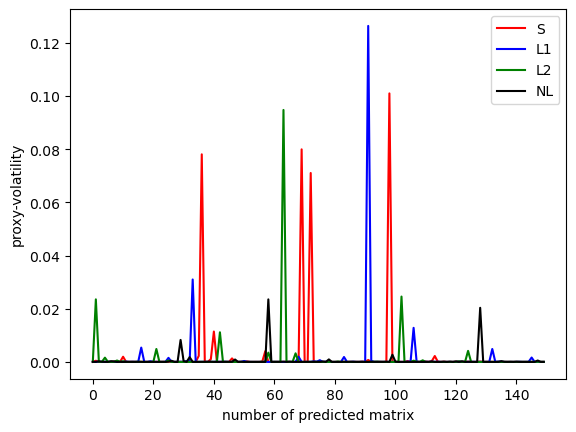

In [36]:
# You can choose different start and end params for more/less detailed picture
# Non-linear shrinkage has the least number of volatilities explosion
# So that way of matrix regularization shows its own power
start = 0
end = 150
plt.plot(volatility_results['S']['volatilities in-sample list'][start:end], color='red', label='S')
plt.plot(volatility_results['L1']['volatilities in-sample list'][start:end], color='blue', label='L1')
plt.plot(volatility_results['L2']['volatilities in-sample list'][start:end], color='green', label='L2')
plt.plot(volatility_results['NL']['volatilities in-sample list'][start:end], color='black', label='NL')
plt.xlabel('number of predicted matrix')
plt.ylabel('proxy-volatility')
plt.legend()
plt.show()

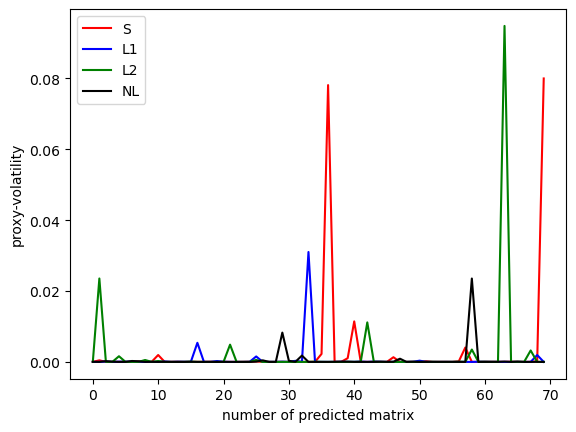

In [38]:
start = 0
end = 70
plt.plot(volatility_results['S']['volatilities out-of-sample list'][start:end], color='red', label='S')
plt.plot(volatility_results['L1']['volatilities out-of-sample list'][start:end], color='blue', label='L1')
plt.plot(volatility_results['L2']['volatilities out-o-sample list'][start:end], color='green', label='L2')
plt.plot(volatility_results['NL']['volatilities in-sample list'][start:end], color='black', label='NL')
plt.xlabel('number of predicted matrix')
plt.ylabel('proxy-volatility')
plt.legend()
plt.show()